## Evaluate the Koshland-Goldbeter model as a description for the complete DMS dataset

Here we re-fit and evaluate the Koshland and Goldbeter model across the entire DHFR DMS dataset in the context of WT, Q33S, and R166Q TYMS. We start by fitting the model using point mutations that were previously catalytically characterized in vitro. We then use these best-fit parameters to infer kinetic parameters and examine model correspondence across the complete dataset. Finally, we explore the space of kinetic parameters inferred across the DMS dataset.

May 2022 - K. Reynolds

In [1]:
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import random
import pickle
import seaborn as sns
import math
import copy
import matplotlib.colors as colors

from scipy import stats
from scipy.optimize import least_squares
from scipy.optimize import basinhopping

from datetime import date

from random import randint

from biopandas.pdb import PandasPdb

#set up the plotting environment
import plot_style
plot_style.change_plot_defaults()

### Import all of the relevant data (growth rates, biochemical parameters, and initial model fits based on plate reader data)

#### Relative growth rates (and errors) obtained by sequencing

In [2]:
#reference set of AA positions (indices) in each sublibrary
aa_pos = [np.arange(1,40+1),np.arange(41,80+1),\
        np.arange(81,120+1),np.arange(121,160+1)]

#growth rates as calculated in 2_DMSGrowthRates.ipynb and then
#filtered in 3_Epistasis.ipynb
# gr_filt only includes DHFR variants with three replicate measurements
# (mutations that were absent from the library or showed insufficient reads 
# to allow growth rate fitting in at least one replicate are replaced with a nan)
# data were then further filtered to truncate the first DHFR position and stop codons.
# mutations with negative growth rates are set to nan as well.
#WT alleles at each position have a fitness of 1

fin = open('Output/Epistasis.pkl','rb')
epi_data = pickle.load(fin)
gr_mean = epi_data['gr_filt']
gr_std = epi_data['gr_filt_std']
WTAAmask_ori = epi_data['WTAAmask']
WTAAmask = WTAAmask_ori[1:,:-1]
fin.close()

#epistasis (and errors) as calculated in 3_Epistasis.ipynb
epi = epi_data['epi']
epi_std = epi_data['epi_std']
fin.close()

#epistatic clusters as calculated in 3_Epistasis.ipynb
epi_clust = epi_data['clust']
epi_sig = epi_data['epi_sig']

#residues sorted by distance from the active site (as in 3_Epistasis.ipynb)
res_distsort = epi_data['res_distsort']
distsort = epi_data['distsort']

#experimental parameters
TYMS_mut = list(gr_mean.keys())

#define the size of the mutational space
#and specify the sequence (and range) of each sublibrary
Npos = 159 
AA = 'GAVLMIFYWKRHDESTCNQP*' #here we order the amino acids by biochemical similarity
NAA = len(AA)
NAA_nostop = NAA - 1
wt_aa_sequence= {}
wt_aa_sequence['sl1']= 'MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPV'
wt_aa_sequence['sl2']= 'IMGRHTWESIGRPLPGRKNIILSSQPGTDDRVTWVKSVDE'
wt_aa_sequence['sl3']= 'AIAACGDVPEIMVIGGGRVYEQFLPKAQKLYLTHIDAEVE'
wt_aa_sequence['sl4']= 'GDTHFPDYEPDDWESVFSEFHDADAQNSHSYCFEILERR*'
wt_aa_seqfull = wt_aa_sequence['sl1']+wt_aa_sequence['sl2']+wt_aa_sequence['sl3']+wt_aa_sequence['sl4']

#### DHFR and TYMS kinetics data

In [3]:
#the mutant lists are sorted by catalytic power (kcat/Km)
TYMS_mut = ['WT','Q33S','R166Q']

#catalytic activities for DHFR are taken from Reynolds et al 2011 + Thompson et al 2020
#catalytic activities for TYMS were collected by Chris Ingle in triplicate
DHFR_kcat, DHFR_Km = {}, {}, 
DHFR_kcat_std, DHFR_Km_std = {},{} 
flines = open('Input/kinetics_dhfr.txt').readlines()[1:]
for line in flines:
    sp = line.split()
    DHFR_kcat[sp[0]] = float(sp[1])
    DHFR_Km[sp[0]] = float(sp[2])
    if len(sp) < 4:
        DHFR_kcat_std[sp[0]] = np.nan
        DHFR_Km_std[sp[0]] = np.nan
    else:
        DHFR_kcat_std[sp[0]] = float(sp[3])
        DHFR_Km_std[sp[0]] = float(sp[4])

DHFR_mut = [i for i in list(DHFR_kcat.keys()) if '.' not in i]
#DHFR_mut = ['M42F','WT','F31Y','G121V','D27N']
#DHFR_mut = ['L54F','WT','M42F','L28F','T113V','M20Q','L28Y','V13H','E17V','F31Y','L54I','W22H','F31V','G121V',\
#            'I5K','D27N']
negkcat_Km = [-DHFR_kcat[m]/DHFR_Km[m] for m in DHFR_mut]
DHFR_mut = [DHFR_mut[i] for i in np.argsort(negkcat_Km)]
dhkcat_sel,dhkm_sel = np.zeros(len(DHFR_mut)),np.zeros(len(DHFR_mut))
dhkcat_std_sel,dhkm_std_sel = np.zeros_like(dhkcat_sel),np.zeros_like(dhkm_sel)
for i,dh in enumerate(DHFR_mut):
    dhkcat_sel[i] = DHFR_kcat[dh]
    dhkm_sel[i] = DHFR_Km[dh]
    dhkcat_std_sel[i] = DHFR_kcat_std[dh]
    dhkm_std_sel[i] = DHFR_Km_std[dh]
                             
TYMS_kcat, TYMS_Km = {}, {}
TYMS_kcat_std, TYMS_Km_std = {},{}
flines = open('Input/kinetics_tyms.txt').readlines()[1:]
for line in flines:
    sp = line.split()
    TYMS_kcat[sp[0]] = float(sp[1])
    TYMS_Km[sp[0]] = float(sp[2])
    TYMS_kcat_std[sp[0]] = float(sp[3])
    TYMS_Km_std[sp[0]] = float(sp[4])
    
tskcat_sel, tskm_sel = np.zeros(len(TYMS_mut)), np.zeros(len(TYMS_mut))
tskcat_std_sel, tskm_std_sel = np.zeros(len(TYMS_mut)), np.zeros(len(TYMS_mut))
for i,ts in enumerate(TYMS_mut):
    tskcat_sel[i] = TYMS_kcat[ts]
    tskm_sel[i] = TYMS_Km[ts]
    tskcat_std_sel[i] = TYMS_kcat_std[ts]
    tskm_std_sel[i] = TYMS_Km_std[ts]

#### Import the best fit model from the plate reader data 

(this should be a reasonable starting point for fitting the sequencing dataset)

In [4]:
fin = open('Output/2023-04-17_model_fitplatedata.pkl','rb')
KGfit_plate = pickle.load(fin)
KGfit_plate

{'Ftot': 95.42571913960434,
 'c_ts': array([ 0.07672601,  0.28185003,  0.22598295, 21.1757512 ]),
 'c_dh': 3.1632867081062406,
 'g_params': array([0.64603418, 0.61568256, 1.40884237, 0.1999999 ])}

### Define the model fitting functions 

(these are a subset of the model fitting functions in 1_KGModel.ipynb, but are otherwise identical)

In [5]:
def gr_depSigmoid(K,n,gmax,gmin,metab):
    '''
    Sigmoidal function relating metabolite concentration to growth rate.
    
    **Arguments:**
        K = metabolite concetration at 50% of maximal growth
        n = hill coefficient
        gmax = max growth rate
        gmin = min growth rate
        metab = metabolite concetrations
    '''
    gr = (gmax - gmin)/(1 + (K/metab)**n) + gmin
    return gr

def concTHF(Ftot,c_ts,c_dh,kc_ts,kc_dh,km_ts,km_dh):
    '''
    Calculate the steady state concentration of THF 
    using the Koshland-Goldbeter equation
    
    Returns the fraction of the total folate pool that
    corresponds to THF
    
    **Arguments:**
        Ftot = total folate pool
        c_ts = relative abundance of TYMS
        c_dh = relative abundace of DHFR
        kc_ts = kcat TYMS
        kc_dh = kcat DHFR
        km_ts = Km TYMS
        km_dh = Km DHFR
    '''
    v1 = kc_dh*c_dh
    v2 = kc_ts*c_ts
    km1 = km_dh/Ftot
    km2 = km_ts/Ftot
    p1 = (v1/v2)*(1-km2) - km1 - 1
    p2 = np.sqrt(4*km2*(v1/v2)*(v1/v2 - 1) + ((v1/v2)*(km2 - 1)+km1 + 1)**2)
    fracTHF = (p1 + p2)/(2*(v1/v2 - 1))
    return fracTHF
    
def calcGR(Ftot,c_ts_wt,c_ts,c_dh,kc_tsmut,kc_dhmut,km_tsmut,km_dhmut,g_params,calcTHF=False,vec_calc=False):
    '''
    Calculate the growth rate for select DHFR and TYMS mutant combinations
    given parameters for the KG model and THF-growth rate relationship.
    
    **Arguments:**
        Ftot = total folate pool
        c_ts_wt = the WT TYMS concentration, so that we do not assume it is present in c_ts
        c_ts = relative abundance of TYMS
        c_dh = relative abundace of DHFR
        kc_tsmut = kcat TYMS
        kc_dhmut = kcat DHFR
        km_tsmut = Km TYMS
        km_dhmut = Km DHFR
        g_params = array of four parameters for gr_depSigmoid (K,n,gmax,gmin)
        calcTHF = if true, also return an array of calculated THF values
        vec_cal = if true, calculate growth rates over matched vectors of DHFR and TYMS mutant
                  combinations (rather than over all possible pairwise combinations, see below)
    returns the estimated growth rates as either a scalar, array, or Ndh * Nts 
    matrix, depending on the number of input DHFR and TYMS kinetic parameters
    '''
    K,n,gmax,gmin = g_params
    
    #calculate growth rates over a vector of DHFR and TYMS mutant combinations
    #(in contrast to the matrix-based calculations, this approach does not
    # calculate growth rates across all DHFR/TYMS combinations but only for
    # a pre-specified list of DHFR and TYMS values)
    if vec_calc:
        gr = np.zeros(len(c_ts))
        thf = np.zeros_like(gr)
        thfWT = concTHF(Ftot,c_ts_wt,c_dh,TYMS_kcat['WT'],DHFR_kcat['WT'],TYMS_Km['WT'],DHFR_Km['WT'])
        for i in range(len(c_ts)):
                thfMut = concTHF(Ftot,c_ts[i],c_dh,kc_tsmut[i],kc_dhmut[i],km_tsmut[i],km_dhmut[i])
                relTHF = thfMut/thfWT
                thf[i] = relTHF
                gr[i] =gr_depSigmoid(K,n,gmax,gmin,relTHF)
        if calcTHF:
            return gr,thf
        else:
            return gr
    
    #calculate a growth rate matrix - dimensions N_dhfr rows, N_tyms columns
    elif hasattr(kc_tsmut, "__len__") and hasattr(kc_dhmut, "__len__"):
        gr = np.zeros((len(kc_dhmut),len(kc_tsmut)))
        thf = np.zeros_like(gr)
        thfWT = concTHF(Ftot,c_ts_wt,c_dh,TYMS_kcat['WT'],DHFR_kcat['WT'],TYMS_Km['WT'],DHFR_Km['WT'])
        for i in range(len(kc_dhmut)):
            for j in range(len(kc_tsmut)):
                thfMut = concTHF(Ftot,c_ts[j],c_dh,kc_tsmut[j],kc_dhmut[i],km_tsmut[j],km_dhmut[i])
                relTHF = thfMut/thfWT
                thf[i,j] = relTHF
                gr[i,j] =gr_depSigmoid(K,n,gmax,gmin,relTHF)
        if calcTHF:
            return gr,thf
        else:
            return gr
    
    #calculate a growth rate vector, calculates growth rates for a single DHFR mut
    #in different TYMS backgrounds
    elif hasattr(kc_tsmut, "__len__") and not(hasattr(kc_dhmut, "__len__")):
        gr = np.zeros(len(kc_tsmut))
        thf = np.zeros_like(gr)
        thfWT = concTHF(Ftot,c_ts_wt,c_dh,TYMS_kcat['WT'],DHFR_kcat['WT'],TYMS_Km['WT'],DHFR_Km['WT'])
        for j in range(len(kc_tsmut)):
            thfMut = concTHF(Ftot,c_ts[j],c_dh,kc_tsmut[j],kc_dhmut,km_tsmut[j],km_dhmut)
            relTHF = thfMut/thfWT
            thf[j] = relTHF
            gr[j] = gr_depSigmoid(K,n,gmax,gmin,relTHF)
        if calcTHF:
            return gr,thf
        else:
            return gr
    
    #calculate a single growth rate value, for one DHFR/TYMS combination
    else:
        thfMut = concTHF(Ftot,c_ts,c_dh,kc_tsmut,kc_dhmut,km_tsmut,km_dhmut)
        thfWT = concTHF(Ftot,c_ts_wt,c_dh,TYMS_kcat['WT'],DHFR_kcat['WT'],TYMS_Km['WT'],DHFR_Km['WT'])
        relTHF = thfMut/thfWT
        gr = gr_depSigmoid(K,n,gmax,gmin,relTHF)
        if calcTHF:
            return gr, relTHF
        else:
            return gr
    

def bootstrap_sample(obs_grates, Nsamp):
    N_dh, N_ts = obs_grates.shape
    dh_samp, ts_samp, grate_samp = [],[],[]
    for s in range(Nsamp):
        dh_samp.append(randint(0,N_dh-1))
        ts_samp.append(randint(0,N_ts-1))
        grate_samp.append(obs_grates[dh_samp[-1],ts_samp[-1]])
    return dh_samp, ts_samp, grate_samp

def resids_grates_bootstrap(p,N_ts,ts_id,dh_id,obs_grates):
    Ftot = p[0]
    cts =p[1:1+N_ts]
    cdh=p[1+N_ts]
    g_params = p[N_ts+2:]
    
    cts_vec = [cts[i] for i in ts_id]
    kc_ts = [tskcat_sel[i] for i in ts_id]
    km_ts = [tskm_sel[i] for i in ts_id]
    kc_dh = [dhkcat_sel[i] for i in dh_id]
    km_dh = [dhkm_sel[i] for i in dh_id]
    gr_est = calcGR(Ftot,cts[0],cts_vec,cdh,kc_ts,kc_dh,km_ts,km_dh,g_params,vec_calc=True)
    
    err = gr_est - obs_grates
    if (sum(np.isnan(err)) > 0):
        return 1000
    else:
        return err
    
def resids_grates(p,kc_ts,kc_dh,km_ts,km_dh,obs_grates,holdout=np.nan,cts='mult'):
    '''
    Calculate the difference between the observed and calculated
    growth rates, given a set of DHFR and TYMS catalytic parameters, 
    and selected fit parameters (p). Used to fit the complete set of 
    model parameters from a growth rate dataset. 
    
    **Arguments: **
        p = array of fit parameters (Ftot,cts,cdh,parameters for growth rate sigmoid)
        kc_ts = kcat TYMS
        kc_dh = kcat DHFR
        km_ts = Km TYMS
        km_dh = Km DHFR
        obs_grates = observed (experimental) growth rates
        holdout = (optional) data point to exclude during fitting
        cts = (optional) argument to specify if you wish to only fit a subset of tyms concentration values
              'mult' fits a tyms concentration for each mutant
              'two' fits two tyms concentrations - one for R166Q and one for everything else
               any other string results in fitting only a single tyms concentration parameter
    
    The holdout parameter is used to estimate sensitivity of the model fit parameters
    on the dataset (by excluding a single data point when fitting the data)
    
    The function assumes that the observed growth rates are organized such that the
    (rows) match to the dhfr variants as orderd in kc_dh and km_dh, and that the 
    (columns) match to the tyms variants as ordered in kc_ts and km_ts
    '''
    
    #select whether to fit: (1) a unique relative concentration of TYMS for each
    #TYMS variant, OR (2) a relative concentration for TYMS R166Q and a single parameter for
    #all of the others OR (3) a single relative concentration of TYMS for all variants (one parameter)
    if (cts=='mult'):
        Ftot = p[0]
        cts =p[1:1+len(kc_ts)]
        cdh=p[1+len(kc_ts)]
        g_params = p[len(kc_ts)+2:]
    
    elif (cts == 'two'):
        Ftot = p[0]
        cts =np.ones(len(kc_ts))*p[1]
        cts[-1] = p[2]
        cdh=p[3]
        g_params = p[4:]
    
    else: 
        Ftot = p[0]
        cts =np.ones(len(kc_ts))*p[1]
        cdh=p[2]
        g_params = p[3:]
        
    gr_est = calcGR(Ftot,cts[0],cts,cdh,kc_ts,kc_dh,km_ts,km_dh,g_params)
    
    if np.isnan(holdout):
        err = gr_est.flatten() - obs_grates.flatten()
    else:
        err = np.delete(gr_est,holdout) - np.delete(obs_grates,holdout)
    return err


### Define functions for inferring catalytic parameters given growth rate data

These functions are used to evaluate the model as a description across the entire dataset.

In [6]:
def growth_obj(cat_params, gr_obs, tskc, tskm, p):
    '''
    Objective function for minimization, when estimating DHFR catalytic parameters from growth rate data
    Calculates the RMSD between the observed (gr_obs) and estimated growth rates 
    Given a specific choice of DHFR catalytic parameters (cat_params)
    
    **Arguments:**
        cat_params = a vector containing the selected DHFR kcat and Km [dh_kcat, dh_km]
        gr_obs = the observed growth rates for a given DHFR mutant across multiple TYMS backgrounds
        tskc = the TYMS kcat values corresponding to each TYMS background
        tskm = the TYMS Km values corresponding to each TYMS background
        p = the best-fit parameters for the Koshland-Goldbeter based growth rate model 
        
    returns the RMSD between the observed and predicted growth rate data for a given choice of
    DHFR kcat and Km 
    '''
    Ftot = p[0]
    cts =p[1:1+len(tskc)]
    cdh=p[1+len(tskc)]
    g_params = p[2+len(tskc):]
    gr_est = calcGR(Ftot,cts[0],cts,cdh,tskc,cat_params[0],tskm,cat_params[1],g_params)
    err = np.sqrt(np.sum((gr_est - gr_obs)**2))
    return err

def it_bh2(gr,gr_err,niter,tskc,tskm,p):
    '''
    Solves for DHFR catalytic parameters that minimize the difference between an observed set of 
    growth rate measurements (gr) and the predictions. The minimizer is basinhopping, from scipy optimize.
    The function runs niter rounds of optimization, for each round the growth rates are sampled from a 
    normal distribution governed by the mean and standard deviation of our experimental measurements. 
    The optimal kcat and Km for each round of optimization are stored in the numpy array sols.
    
    **Arguments:**
        gr = the experimentally observed mean growth rates across a set of TYMS backgrounds
        gr_err = the experimentally observed std deviation in growth rates across a set of TYMS backgrounds
        niter = the number of iterations to perform
        p = the parameters for the Koshland-Goldbeter based growth rate model 
    
    returns sols, a vector of niter solutions - each solution consists of a paired kcat, Km value.
    '''
    bds = ((0.01,100),(0.1,1000))
    sols = np.zeros((niter,2))
    x0_kcat = np.random.uniform(bds[0][0],bds[0][1],niter)
    x0_km = np.random.uniform(bds[1][0],bds[1][1],niter)
    for i in range(niter):
        x0 = [x0_kcat[i],x0_km[i]]
        gr_var = [np.random.normal(gr[i],e) for i,e in enumerate(gr_err)]
        minargs = (gr_var,tskc,tskm,p)
        inputargs = {'bounds': bds, 'args': minargs}
        solution = basinhopping(growth_obj,x0,minimizer_kwargs=inputargs)
        sols[i,:] = solution.x
    return sols


### Fit and evaluate the model across all biochemically characterized single mutations.

We consider the accuracy of the model growth rate predictions using both (1) parameters fit from the smaller set of plate reader data (as determined in 1_KGModel.ipynb) and (2) parameters fit using the expanded set of characterized point mutations included in the DMS experiment. We evaluate the correlation between our model predictions and experimentally measured growth rates and epistasis across the complete set of catalytically charcterized point mutations: 41 DHFR x 3 TYMS = 124 mutations in total.

For parameter estimation using the sequencing data, we bootstrap sample the data to obtain confidence intervals. Briefly, experimentally determined growth rates for catalytically characterized DHFR/TYMS variants are sampled (with replacement) and used to fit the model parameters 1000 times. For each sampling, we calculate growth rate and epistasis across the full data set using the best fit parameters. We take the standard deviation across these 1000 resamplings as an estimate of imprecision in the inferred parameters and the accompnaying growth rates/epistasis. 

In [7]:
#define initial fitting parameters
p0 = [KGfit_plate['Ftot'],KGfit_plate['c_ts'][0],KGfit_plate['c_ts'][1],KGfit_plate['c_ts'][3],KGfit_plate['c_dh'],\
      KGfit_plate['g_params'][0],KGfit_plate['g_params'][1],KGfit_plate['g_params'][2],\
      KGfit_plate['g_params'][3]]
#p0 = [5.4713,0.14,0.27,0.33,0.08,0.036,1.57,1.02,0.19]
bds = ([1E-5,1E-5,1E-5,1E-5,1E-5,0.001,0,0.6,0],[100,100,100,100,100,5,10,1.5,0.2])

#### organize the growth rate data for the focused set of mutations
grates_sel = np.zeros((len(DHFR_mut),len(TYMS_mut)))
grates_sel_std = np.zeros_like(grates_sel)
epi_sel,epi_sel_std = np.zeros_like(grates_sel),np.zeros_like(grates_sel)
for i,dmut in enumerate(DHFR_mut):
    for j,tmut in enumerate(TYMS_mut):
        if dmut == 'WT':
            grates_sel[i,j] = 1
            grates_sel_std[i,j] = 0
            epi_sel[i,j] = 0
            epi_sel_std[i,j]= 0
        else:    
            p = int(dmut[1:-1])-2
            a = AA.index(dmut[-1])
            grates_sel[i,j] = gr_mean[tmut][p,a]
            grates_sel_std[i,j] = gr_std[tmut][p,a]
            if tmut == 'WT':
                epi_sel[i,j] = 0
                epi_sel_std[i,j] = 0
            else:
                epi_sel[i,j] = epi[tmut][p,a]
                epi_sel_std[i,j] = epi_std[tmut][p,a]

#### remove any nan growth rate entries from the test set
nanix = np.argwhere(np.isnan(grates_sel))
grates_sel = np.delete(grates_sel,nanix[:,0],axis=0)
grates_sel_std = np.delete(grates_sel_std,nanix[:,0],axis=0)
epi_sel = np.delete(epi_sel,nanix[:,0],axis=0)
epi_sel_std = np.delete(epi_sel_std,nanix[:,0],axis=0)

#remove kcat and km measurements that accompany the mutants with nan growth rate
dhkcat_sel = np.delete(dhkcat_sel,nanix[:,0])
dhkm_sel = np.delete(dhkm_sel,nanix[:,0])

#remove kcat and km error measurements that accompany the mutants with nan growth rate
dhkcat_std_sel = np.delete(dhkcat_std_sel,nanix[:,0])
dhkm_std_sel = np.delete(dhkm_std_sel,nanix[:,0])

#finally remote the mutants from the mut list
DHFR_mut = list(np.delete(DHFR_mut,nanix[:,0]))

Fit parameters from plate reader data - Ftot: 95.43,     TYMS: 0.08,0.28,21.18,DHFR: 3.16, K: 0.65,n:0.62, mx:1.41,     mn: 0.20 
*** RMSD between the model and data - using params fit on plate reader data: 0.18
*** R2: 0.29
Best fit across mutations in sequencing set - Ftot: 48.11 (+/-26.46),    TYMS: 3.73 (+/-2.36),7.05 (+/-3.61),49.94 (+/-32.31),    DHFR: 3.20 (+/-1.88), K: 0.30 (+/-0.15),n:0.92 (+/-1.49), mx:1.41 (+/-0.18),     mn: 0.12 (+/-0.08)
*** RMSD between the model and data - using refit params for full model: 0.08
*** R2: 0.84


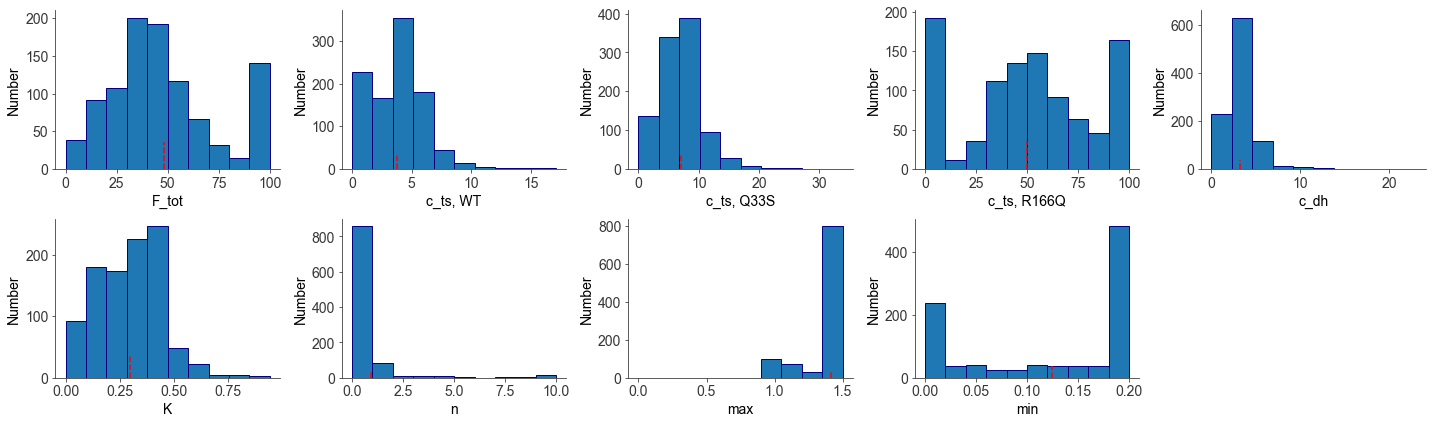

In [8]:
#### calculate growth rates, epistasis using the initial parameter choices
# (these are the best fit values from the plate reader data)
gr_pred_oriparams = calcGR(p0[0],p0[1],[p0[1],p0[2],p0[3]],p0[4],\
                           tskcat_sel,dhkcat_sel,tskm_sel,dhkm_sel,p0[5:])

epi_pred_oriparams = np.zeros_like(gr_pred_oriparams)
dhwt_ix = DHFR_mut.index('WT')
for d in range(len(dhkcat_sel)):
            for t in range(len(tskcat_sel)):
                epi_pred_oriparams[d,t] = gr_pred_oriparams[d,t] + \
                                (gr_pred_oriparams[dhwt_ix,0] - gr_pred_oriparams[d,0] - gr_pred_oriparams[dhwt_ix,t])

#assess fit quality using the original set of best fit parameters (from the plate reader data)
nn = ~np.isnan(grates_sel.flatten())
N_meas = np.sum(nn)
rmsd_orifit = np.sqrt(np.sum((gr_pred_oriparams.flatten()[nn] - grates_sel.flatten()[nn])**2)/N_meas)
r2_orifit = np.corrcoef(grates_sel.flatten()[nn],gr_pred_oriparams.flatten()[nn])[0,1]**2
print('Fit parameters from plate reader data - Ftot: %1.2f, \
    TYMS: %1.2f,%1.2f,%1.2f,DHFR: %1.2f, K: %1.2f,n:%1.2f, mx:%1.2f, \
    mn: %1.2f ' % (p0[0],p0[1],p0[2],p0[3],p0[4],p0[5],p0[6],p0[7],p0[8]))
print('*** RMSD between the model and data - using params fit on plate reader data: %1.2f' % rmsd_orifit)
print('*** R2: %1.2f' % r2_orifit)


#### BOOTSTRAP ANALYSIS
# perform the model fit 1000 times across resampled groups of DHFR/TYMS point mutants
boot_iter = 1000
Ftot_samp =np.zeros((boot_iter,1))
c_ts_samp = np.zeros((boot_iter,3))
c_dh_samp = np.zeros((boot_iter,1))
g_params_samp = np.zeros((boot_iter,4))
gr_pred_samp = np.zeros((boot_iter,len(dhkcat_sel),len(tskcat_sel)))
epi_pred_samp = np.zeros((boot_iter,len(dhkcat_sel),len(tskcat_sel)))

for i in range(boot_iter):
    dh_samp, ts_samp, grate_samp = bootstrap_sample(grates_sel, np.size(grates_sel))
    kg_fit = least_squares(resids_grates_bootstrap,p0,\
                               args=(len(TYMS_mut),ts_samp,dh_samp,grate_samp),\
                               bounds=bds)
    if kg_fit.success:
        Ftot_samp[i] = kg_fit.x[0]
        c_ts_samp[i,:] = kg_fit.x[1:4]
        c_dh_samp[i] = kg_fit.x[4]
        g_params_samp[i,:] = kg_fit.x[5:]
        gr_pred_samp[i,:,:] = calcGR(Ftot_samp[i],c_ts_samp[i,0],c_ts_samp[i,:],c_dh_samp[i],\
                                 tskcat_sel,dhkcat_sel,tskm_sel,dhkm_sel,\
                                 g_params_samp[i,:])
        for d in range(len(dhkcat_sel)):
            for t in range(len(tskcat_sel)):
                epi_pred_samp[i,d,t] = gr_pred_samp[i,d,t] + \
                                (gr_pred_samp[i,dhwt_ix,0] - gr_pred_samp[i,d,0] - gr_pred_samp[i,dhwt_ix,t])

    
#calculate means and error on the parameters (across bootstrap samples)
Ftot, Ftot_std = np.mean(Ftot_samp),np.std(Ftot_samp)
c_ts, c_ts_std = np.mean(c_ts_samp,0),np.std(c_ts_samp,0)
c_dh, c_dh_std = np.mean(c_dh_samp),np.std(c_dh_samp)
g_params, g_params_std = np.mean(g_params_samp,0),np.std(g_params_samp,0)

#and report the best fit values:
print('Best fit across mutations in sequencing set - Ftot: %1.2f (+/-%1.2f),\
    TYMS: %1.2f (+/-%1.2f),%1.2f (+/-%1.2f),%1.2f (+/-%1.2f),\
    DHFR: %1.2f (+/-%1.2f), K: %1.2f (+/-%1.2f),n:%1.2f (+/-%1.2f), mx:%1.2f (+/-%1.2f), \
    mn: %1.2f (+/-%1.2f)' % (Ftot,Ftot_std,c_ts[0],c_ts_std[0],c_ts[1],c_ts_std[1],\
                             c_ts[2],c_ts_std[2],c_dh,c_dh_std,\
                            g_params[0],g_params_std[0],g_params[1],g_params_std[1],\
                            g_params[2],g_params_std[2],g_params[3],g_params_std[3]))


#calculate means and error on growth rates
gr_pred, gr_pred_err = np.mean(gr_pred_samp,0),np.std(gr_pred_samp,0)

#calculate means and error on epistasis
epi_pred, epi_pred_err = np.mean(epi_pred_samp,0),np.std(epi_pred_samp,0)

#assess fit quality for the best fit model (averaging across bootstrap replicates)
rmsd_bestfit = np.sqrt(np.sum((gr_pred.flatten()[nn] - grates_sel.flatten()[nn])**2)/N_meas)
r2_bestfit = np.corrcoef(grates_sel.flatten()[nn],gr_pred.flatten()[nn])[0,1]**2
print('*** RMSD between the model and data - using refit params for full model: %1.2f' % rmsd_bestfit)
print('*** R2: %1.2f' % r2_bestfit)

#plot distributions of best fit parameters with means indicated. 
plt.figure(figsize =(20,6))
plt.subplot(2,5,1)
plt.hist(Ftot_samp,edgecolor='navy')
plt.plot([Ftot,Ftot],[0,36],'--r')
plt.xlabel('F_tot',fontsize=14); plt.ylabel('Number',fontsize=14)
plt.subplot(2,5,2)
plt.hist(c_ts_samp[:,0],edgecolor='navy')
plt.plot([c_ts[0],c_ts[0]],[0,36],'--r')
plt.xlabel('c_ts, WT',fontsize=14); plt.ylabel('Number',fontsize=14)
plt.subplot(2,5,3)
plt.hist(c_ts_samp[:,1],edgecolor='navy')
plt.plot([c_ts[1],c_ts[1]],[0,36],'--r')
plt.xlabel('c_ts, Q33S',fontsize=14); plt.ylabel('Number',fontsize=14)
plt.subplot(2,5,4)
plt.hist(c_ts_samp[:,2],edgecolor='navy')
plt.plot([c_ts[2],c_ts[2]],[0,36],'--r')
plt.xlabel('c_ts, R166Q',fontsize=14); plt.ylabel('Number',fontsize=14)
plt.subplot(2,5,5)
plt.hist(c_dh_samp,edgecolor='navy')
plt.plot([c_dh,c_dh],[0,36],'--r')
plt.xlabel('c_dh',fontsize=14); plt.ylabel('Number',fontsize=14)
plt.subplot(2,5,6)
plt.hist(g_params_samp[:,0],edgecolor='navy')
plt.plot([g_params[0],g_params[0]],[0,36],'--r')
plt.xlabel('K',fontsize=14); plt.ylabel('Number',fontsize=14)
plt.subplot(2,5,7)
plt.hist(g_params_samp[:,1],edgecolor='navy')
plt.plot([g_params[1],g_params[1]],[0,36],'--r')
plt.xlabel('n',fontsize=14); plt.ylabel('Number',fontsize=14)
plt.subplot(2,5,8)
plt.hist(g_params_samp[:,2],edgecolor='navy')
plt.plot([g_params[2],g_params[2]],[0,36],'--r')
plt.xlabel('max',fontsize=14); plt.ylabel('Number',fontsize=14)
plt.subplot(2,5,9)
plt.hist(g_params_samp[:,3],edgecolor='navy')
plt.plot([g_params[3],g_params[3]],[0,36],'--r')
plt.xlabel('min',fontsize=14); plt.ylabel('Number',fontsize=14)

plt.tight_layout()
plt.savefig('Figs/HistFitParams_SeqData.pdf')

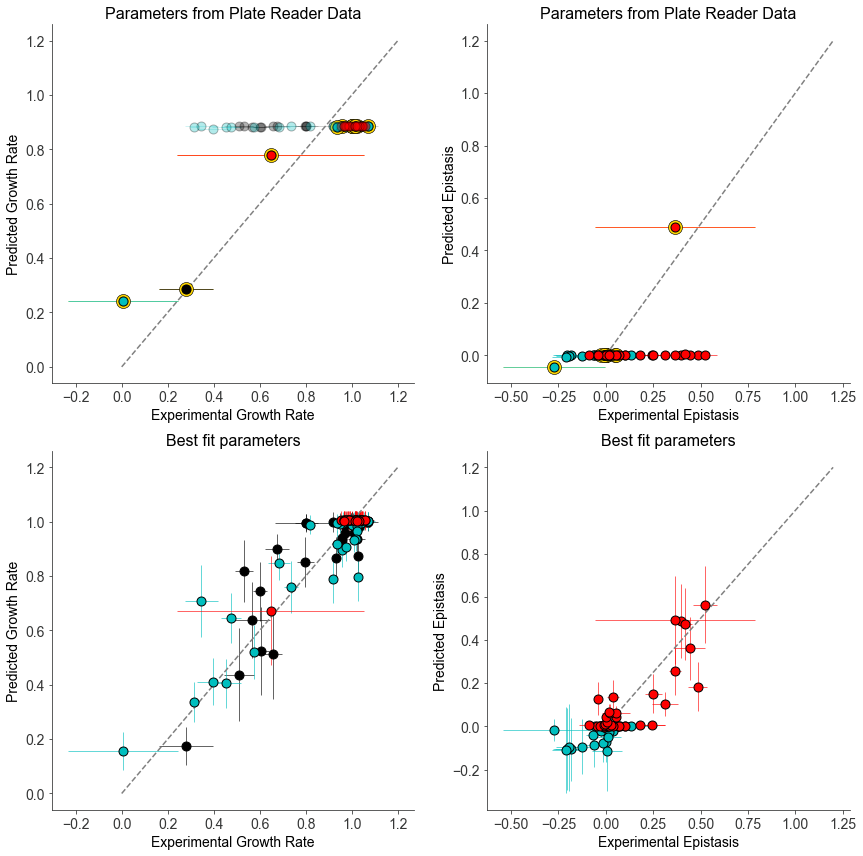

In [9]:
##### Plotting the results
plt.figure(figsize = (12,12))
ts_col = ['k','c','r']
fitMut = ['WT','M42F','F31Y','D27N']

#### predicted vs experimental growth rates (taking parameters from plate reader fit)
plt.subplot(221)
for i,ts in enumerate(TYMS_mut):
    for m in fitMut:
        m_ix = DHFR_mut.index(m)
        plt.errorbar(grates_sel[m_ix,i],gr_pred_oriparams[m_ix,i],xerr=grates_sel_std[m_ix,i],\
                 fmt='o',ms=14,mec='k',color='gold',mfc='gold',elinewidth=0.6,mew=0.6)
        plt.errorbar(grates_sel[m_ix,i],gr_pred_oriparams[m_ix,i],xerr=grates_sel_std[m_ix,i],\
             fmt='o',ms=9,mec='k',color=ts_col[i],mfc=ts_col[i],elinewidth=0.6)
    plt.errorbar(grates_sel[:,i],gr_pred_oriparams[:,i],xerr=grates_sel_std[:,i],\
                 fmt='o',ms=9,mec='k',color=ts_col[i],mfc=ts_col[i],elinewidth=0.6,alpha=0.3)

        
plt.plot([0,1.2],[0,1.2],'--',color='grey')

plt.title('Parameters from Plate Reader Data',fontsize=16)            
plt.xlabel('Experimental Growth Rate', fontsize=14)
plt.ylabel('Predicted Growth Rate', fontsize=14)
#### predicted vs experimental epistasis (taking parameters from plate reader fit)
plt.subplot(222)
for i,ts in enumerate(TYMS_mut):
    for m in fitMut:
        m_ix = DHFR_mut.index(m)
        plt.errorbar(epi_sel[m_ix,i],epi_pred_oriparams[m_ix,i],xerr=epi_sel_std[m_ix,i],\
                 fmt='o',ms=14,mec='k',color='gold',mfc='gold',elinewidth=0.6,mew=0.6)
    plt.errorbar(epi_sel[:,i],epi_pred_oriparams[:,i],xerr=epi_sel_std[:,i],\
                 fmt='o',ms=9,mec='k',color=ts_col[i],mfc=ts_col[i],elinewidth=0.6)
plt.plot([0,1.2],[0,1.2],'--',color='grey')

#uncomment to add text labels for individual mutations on the plot
#for i,dmut in enumerate(DHFR_mut):
#    for j,tmut in enumerate(TYMS_mut):
#            plt.text(grates_sel[i,j],gr_pred_oriparams[i,j]+0.02,dmut+'/'+tmut)

plt.title('Parameters from Plate Reader Data',fontsize=16)            
plt.xlabel('Experimental Epistasis', fontsize=14)
plt.ylabel('Predicted Epistasis', fontsize=14)
   
    
#### predicted vs experimental growth rates (with the bootstrapped parameters, sequencing dataset)
plt.subplot(223)
for i,ts in enumerate(TYMS_mut):
    plt.errorbar(grates_sel[:,i],gr_pred[:,i],xerr=grates_sel_std[:,i],yerr=gr_pred_err[:,i],\
                 fmt='o',color=ts_col[i],ms=9,mec='k',mfc=ts_col[i],elinewidth=0.6)
plt.plot([0,1.2],[0,1.2],'--',color='grey')

#uncomment to add text labels for individual mutations on the plot
#for i,dmut in enumerate(DHFR_mut):
#    for j,tmut in enumerate(TYMS_mut):
#            plt.text(grates_sel[i,j],gr_pred[i,j]+0.02,dmut+'/'+tmut)

plt.title('Best fit parameters',fontsize=16)            
plt.xlabel('Experimental Growth Rate', fontsize=14)
plt.ylabel('Predicted Growth Rate', fontsize=14)  

#### predicted vs experimental epistasis (with the bootstrapped parameters, sequencing dataset)
plt.subplot(224)
for i,ts in enumerate(TYMS_mut):
    plt.errorbar(epi_sel[:,i],epi_pred[:,i],xerr=epi_sel_std[:,i],yerr=epi_pred_err[:,i],\
                 fmt='o',color=ts_col[i],ms=9,mec='k',mfc=ts_col[i],elinewidth=0.6)
plt.plot([0,1.2],[0,1.2],'--',color='grey')

plt.title('Best fit parameters',fontsize=16)            
plt.xlabel('Experimental Epistasis', fontsize=14)
plt.ylabel('Predicted Epistasis', fontsize=14)  

plt.tight_layout()
plt.savefig('Figs/BestFit_ModelSeqData.pdf')

#### Compare the predicted and experimental values as heatmaps
For these plots, we focus only on mutants with experimental growth rates < 0.9 to emphasize mutations with a functional effect (and therefore non-trivial prediction)

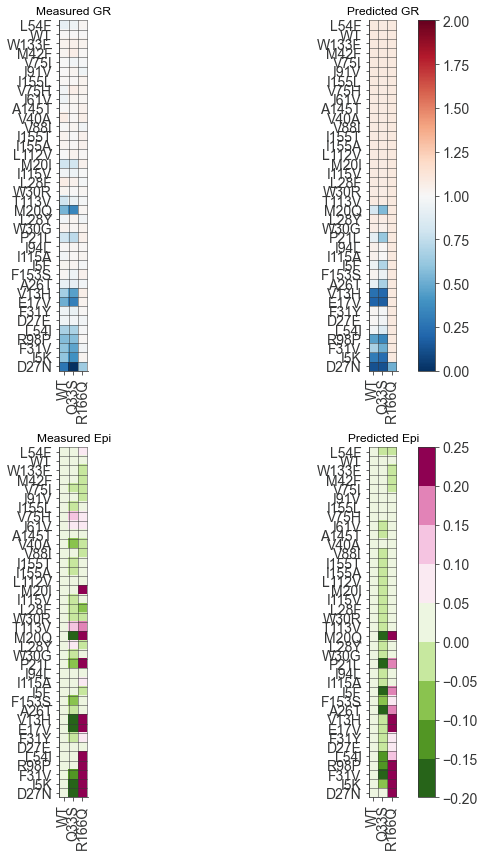

In [10]:
#create heatmap for growth rates
vmn = 0;vmx = 2
norm_gr = colors.TwoSlopeNorm(vmin=vmn, vcenter=1, vmax=vmx)
cmap_gr = copy.copy(plt.cm.get_cmap("RdBu_r"))
cmap_gr.set_bad(color='grey') 

#create discretized colormap for epistasis
bounds = np.arange(-0.2, 0.3, 0.05)
base = plt.cm.get_cmap('PiYG_r')
cmap_discrete = base(np.linspace(0,1,len(bounds)))
newmap = colors.ListedColormap(cmap_discrete)
newmap.set_bad(color='grey') 
norm_epi = colors.BoundaryNorm(bounds,newmap.N)

#create a new matrix of growth rate data, focusing on mutants with a growth rate defect
#in the WT TYMS background
#dhmut_focus = [mut for i,mut in enumerate(DHFR_mut) if grates_sel[i,0] < 0.9]
dhmut_focus = DHFR_mut
grates_focus = np.zeros((len(dhmut_focus),len(TYMS_mut)))
epi_focus = np.zeros_like(grates_focus)
for i,dmut in enumerate(dhmut_focus):
    for j,tmut in enumerate(TYMS_mut):
        if dmut == 'WT':
            grates_focus[i,j] = 1
            epi_focus[i,j] = 0
        else:    
            p = int(dmut[1:-1])-2
            a = AA.index(dmut[-1])
            grates_focus[i,j] = gr_mean[tmut][p,a]
            if tmut == 'WT':
                epi_focus[i,j] = 0
            else:
                epi_focus[i,j] = epi[tmut][p,a]

#re-calculate the growth rates using the median values of the fit parameters
#(as calculated above) and calculate epistasis
gr_pred_focus = np.zeros_like(grates_focus)
epi_pred_focus = np.zeros_like(grates_focus)
for i,dh in enumerate(dhmut_focus):
    for j,ts in enumerate(TYMS_mut):
        gr_pred_focus[i,j] = calcGR(Ftot,c_ts[0],c_ts[j],c_dh,\
                                     TYMS_kcat[ts],DHFR_kcat[dh],TYMS_Km[ts],DHFR_Km[dh],\
                                     g_params) 


for i,dh in enumerate(dhmut_focus):
    for j,ts in enumerate(TYMS_mut):   
        epi_pred_focus[i,j] = gr_pred_focus[i,j] + (gr_pred_focus[dhwt_ix,0] - gr_pred_focus[i,0] \
                                                    - gr_pred_focus[dhwt_ix,j])
        #epi_pred[i,j] = gr_pred[i,j] - gr_pred[i,0] 

plt.figure(num='grates',figsize = (9,12))
plt.subplot(2,2,1)
plt.imshow(grates_focus,cmap=cmap_gr,norm=norm_gr)
plot_style.grid_maker(grates_focus,'grates')

plt.title('Measured GR')
plt.yticks(np.arange(0,len(dhmut_focus)),\
                             labels=dhmut_focus)
plt.xticks(np.arange(0,len(TYMS_mut)),\
                             labels=TYMS_mut,\
                             rotation='vertical')

plt.subplot(2,2,2)
plt.imshow(gr_pred_focus,cmap=cmap_gr,norm=norm_gr)
plot_style.grid_maker(gr_pred_focus,'grates')
plt.title('Predicted GR'); plt.colorbar()
plt.yticks(np.arange(0,len(dhmut_focus)),\
                             labels=dhmut_focus)
plt.xticks(np.arange(0,len(TYMS_mut)),\
                             labels=TYMS_mut,\
                             rotation='vertical')

plt.subplot(2,2,3)
plt.imshow(epi_focus,cmap=newmap,norm=norm_epi)
plot_style.grid_maker(epi_focus,'grates')
plt.title('Measured Epi')
plt.yticks(np.arange(0,len(dhmut_focus)),\
                             labels=dhmut_focus)
plt.xticks(np.arange(0,len(TYMS_mut)),\
                             labels=TYMS_mut,\
                             rotation='vertical')
plt.subplot(2,2,4)
plt.imshow(epi_pred_focus,cmap=newmap,norm=norm_epi)
plot_style.grid_maker(epi_pred_focus,'grates')
plt.title('Predicted Epi'); plt.colorbar()
plt.yticks(np.arange(0,len(dhmut_focus)),\
                             labels=dhmut_focus)
plt.xticks(np.arange(0,len(TYMS_mut)),\
                             labels=TYMS_mut,\
                             rotation='vertical')

plt.tight_layout()
plt.savefig('Figs/PredictedHeatMaps.pdf')

#### Examine where the mutations with experimentally observed sign epistasis fall on our model landscape

In [11]:
#first, we recalculate the epistasis landscapes using our newly fit model parameters
#(that derive from fitting the sequencing-based growth rate emasurements)
#vary over DHFR kcat and DHFR Km
dhkcat_vary = np.logspace(-2,2,50)
dhKm_vary = np.logspace(-1,3,50)

dhkcat_vary = np.append(dhkcat_vary,DHFR_kcat['WT'])
dhKm_vary = np.append(dhKm_vary,DHFR_Km['WT'])

moi = ['M20Q','P21L','V13H','E17V','F31V','I5K', 'D27N']
for m in moi: dhkcat_vary = np.append(dhkcat_vary,DHFR_kcat[m])
for m in moi: dhKm_vary = np.append(dhKm_vary,DHFR_Km[m])
dhkcat_vary = np.sort(dhkcat_vary)
dhKm_vary = np.sort(dhKm_vary)

ix_kcwt = np.where(dhkcat_vary == DHFR_kcat['WT'])
ix_kmwt = np.where(dhKm_vary == DHFR_Km['WT'])
ix_kc_moi,ix_km_moi = [],[]
for m in moi:
    ix_kc_moi.append(np.where(dhkcat_vary == DHFR_kcat[m]))
    ix_km_moi.append(np.where(dhKm_vary == DHFR_Km[m]))


gr_varydh = {}
for i,ts in enumerate(TYMS_mut):
    gr_varydh[ts] = np.zeros((len(dhkcat_vary),len(dhKm_vary)))

    #compute the predicted thf concentration and growth rate for every kcat, Km combination
    #(across each TYMS background)
    for j,kcat in enumerate(dhkcat_vary):
        for k,km in enumerate(dhKm_vary):
            gr = calcGR(Ftot,c_ts[0],c_ts[i],c_dh,TYMS_kcat[ts],kcat,TYMS_Km[ts],km,g_params)
            gr_varydh[ts][j,k] = gr

#Now - we go back and calculate growth rate epistasis for the different TYMS variants
epi_varydh = {}
for i,ts in enumerate(TYMS_mut):
    epi_varydh[ts] = np.zeros((len(dhkcat_vary),len(dhKm_vary)))
    if ts == 'WT':
        kcat_grid = np.zeros((len(dhkcat_vary),len(dhKm_vary)))
        km_grid = np.zeros((len(dhkcat_vary),len(dhKm_vary)))
        for j,dkcat in enumerate(dhkcat_vary):
            for k,dkm in enumerate(dhKm_vary):
                epi_varydh[ts][j,k] = gr_varydh[ts][j,k] + (gr_varydh['WT'][ix_kcwt,ix_kmwt] - gr_varydh[ts][ix_kcwt,ix_kmwt] - gr_varydh['WT'][j,k])
                #epi_varydh[ts][j,k] = gr_varydh[ts][j,k] - gr_varydh['WT'][j,k]
                kcat_grid[j,k] = dkcat
                km_grid[j,k] = dkm

    else:
        for j,dkcat in enumerate(dhkcat_vary):
            for k,dkm in enumerate(dhKm_vary):
                epi_varydh[ts][j,k] = gr_varydh[ts][j,k] + (gr_varydh['WT'][ix_kcwt,ix_kmwt] - gr_varydh[ts][ix_kcwt,ix_kmwt] - gr_varydh['WT'][j,k])
                #epi_varydh[ts][j,k] = gr_varydh[ts][j,k] - gr_varydh['WT'][j,k]

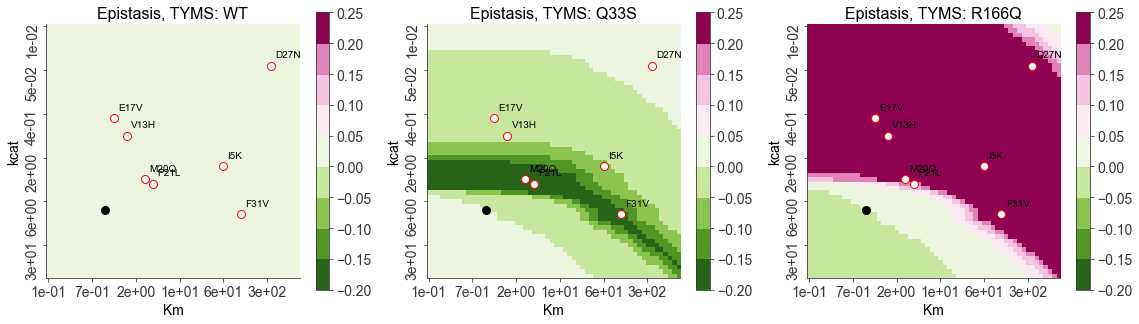

In [12]:
#create heatmaps of  epistasis as a function of DHFR kcat and Km
#for the two TYMS backgrounds, and mark the experimentally characterized point mutations
plt.figure(num='h3',figsize=(16,8))
for i,ts in enumerate(TYMS_mut):
    plt.subplot(1,3,(i+1))
    plt.imshow(epi_varydh[ts],cmap=newmap,norm=norm_epi)
    plt.colorbar(shrink=0.5)

    plt.plot(ix_kmwt,ix_kcwt,'ok',ms=8)
    for i,m in enumerate(moi):
        plt.plot(ix_km_moi[i],ix_kc_moi[i],'ow',ms=8,mec='r')
        plt.text(ix_km_moi[i][0]+1,ix_kc_moi[i][0]-2,m)
    plt.title('Epistasis, TYMS: '+ts,fontsize=16)
    plt.yticks(np.arange(0,len(dhkcat_vary),10),rotation='vertical',\
                             labels=['%1.0e' %dhkcat_vary[i] for i in np.arange(0,len(dhkcat_vary),10)])
    plt.xticks(np.arange(0,len(dhKm_vary),10),\
                             labels=['%1.0e' %dhKm_vary[i] for i in np.arange(0,len(dhKm_vary),10)])
    plt.ylabel('kcat',fontsize=14)
    plt.xlabel('Km',fontsize=14)


plt.tight_layout()

### Fitting catalytic parameters to the remaining point mutations in the dataset

Given that we have a model that relates catalytic parameters to growth rate, can we go in the opposite direction (from growth rates to catalytic parameters)? Here the idea is to use the growth data (in distinct TYMS backgrounds) to constrain the fit of kcat and Km. Standard in vivo Michaelis-Menten kinetics uses measurements of enzyme velocity at varied substrate concentration to quantify steady state parameters, here we are using titrations in intracellular substrate abundance and variation in growth rate (a proxy for velocity) to accomplish the same thing. 

First we consider only the subset of point mutants that were previously biochemically characterized. How well do the data constrain estimates of kcat and Km?

In [13]:
#estimate kcat and Km values
est_kcat,est_kcat_std,est_Km,est_Km_std = [],[],[],[]
fit_params = np.append(np.append(np.append(Ftot,c_ts),c_dh),g_params)
for i,mut in enumerate(DHFR_mut):
    niter=50
    if np.nan in grates_sel[i,:]:
        est_kcat.append(np.nan)
        est_Km.append(np.nan)
        est_kcat_std.append(np.nan)
        est_Km_std.append(np.nan)
    else:    
        sols = it_bh2(grates_sel[i,:],grates_sel_std[i,:],niter,tskcat_sel,tskm_sel,fit_params)
        est_kcat.append(np.median(sols[:,0]))
        est_Km.append(np.median(sols[:,1]))
        est_kcat_std.append(np.std(sols[:,0]))
        est_Km_std.append(np.std(sols[:,1]))

<ipython-input-14-a67b96b51954>:30: RuntimeWarning: invalid value encountered in log10
  logerr_estkcatKm_down.append(np.log10(kcatKm_est[i]/(kcatKm_est[i]- kcatKm_est_std[i])))
<ipython-input-14-a67b96b51954>:28: RuntimeWarning: invalid value encountered in log10
  logerr_kcatKmsel_down.append(np.log10(kcatKm_sel[i]/(kcatKm_sel[i]-kcatKm_sel_std[i])))
<ipython-input-14-a67b96b51954>:20: RuntimeWarning: invalid value encountered in log10
  logerr_estkcat_down.append(np.log10(est_kcat[i]/(est_kcat[i]- est_kcat_std[i])))


R2 between the estimated and observed log10(kcat/Km) is: 0.73


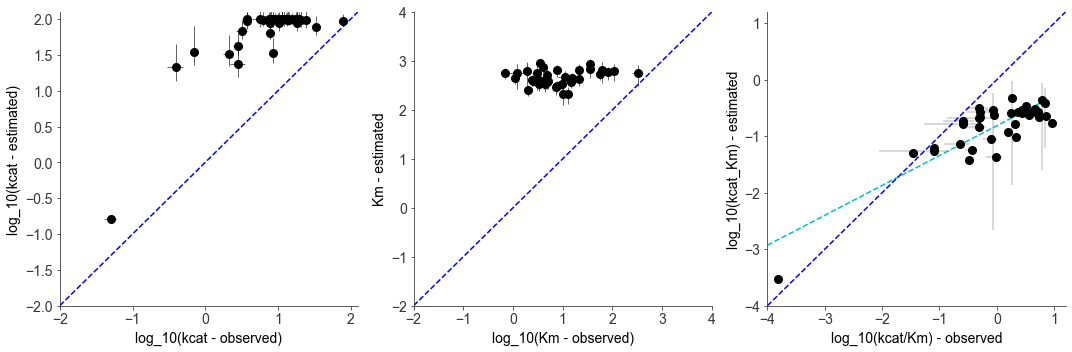

In [14]:
kcatKm_sel = np.array(dhkcat_sel)/np.array(dhkm_sel)
kcatKm_est = np.array(est_kcat)/np.array(est_Km)
kcatKm_sel_std = np.sqrt((np.array(dhkcat_std_sel)/np.array(dhkcat_sel))**2 + \
                         (np.array(dhkm_std_sel)/np.array(dhkm_sel))**2)
kcatKm_est_std = np.sqrt((np.array(est_kcat_std)/np.array(est_kcat))**2 + \
                         (np.array(est_Km_std)/np.array(est_Km))**2)

#propagate error to make log-scale error bars
logerr_kcsel_up,logerr_kcsel_down = [],[]
logerr_estkcat_up, logerr_estkcat_down= [],[]
logerr_Kmsel_up,logerr_Kmsel_down = [],[]
logerr_estKm_up,logerr_estKm_down = [],[]
logerr_kcatKmsel_up,logerr_kcatKmsel_down = [],[]
logerr_estkcatKm_up,logerr_estkcatKm_down = [],[]

for i,mut in enumerate(DHFR_mut):
    logerr_kcsel_up.append(np.log10((dhkcat_sel[i]+ dhkcat_std_sel[i])/dhkcat_sel[i]))
    logerr_kcsel_down.append(np.log10(dhkcat_sel[i]/(dhkcat_sel[i]-dhkcat_std_sel[i])))
    logerr_estkcat_up.append(np.log10((est_kcat[i]+ est_kcat_std[i])/est_kcat[i]))
    logerr_estkcat_down.append(np.log10(est_kcat[i]/(est_kcat[i]- est_kcat_std[i])))
   
    logerr_Kmsel_up.append(np.log10((dhkm_sel[i]+ dhkm_std_sel[i])/dhkm_sel[i]))
    logerr_Kmsel_down.append(np.log10(dhkm_sel[i]/(dhkm_sel[i]-dhkm_std_sel[i])))
    logerr_estKm_up.append(np.log10((est_Km[i]+ est_Km_std[i])/est_Km[i]))
    logerr_estKm_down.append(np.log10(est_Km[i]/(est_Km[i]- est_Km_std[i])))

    logerr_kcatKmsel_up.append(np.log10((kcatKm_sel[i]+ kcatKm_sel_std[i])/kcatKm_sel[i]))
    logerr_kcatKmsel_down.append(np.log10(kcatKm_sel[i]/(kcatKm_sel[i]-kcatKm_sel_std[i])))
    logerr_estkcatKm_up.append(np.log10((kcatKm_est[i]+ kcatKm_est_std[i])/kcatKm_est[i]))
    logerr_estkcatKm_down.append(np.log10(kcatKm_est[i]/(kcatKm_est[i]- kcatKm_est_std[i])))
    
#plot the results
plt.figure(figsize = (15,5))
plt.subplot(131)
plt.errorbar(np.log10(dhkcat_sel),np.log10(est_kcat),xerr=[np.array(logerr_kcsel_down),np.array(logerr_kcsel_up)],\
             yerr=[np.array(logerr_estkcat_up),np.array(logerr_estkcat_down)],fmt='o',color='black',ms=8,\
             elinewidth=0.6,linestyle='')  

plt.plot([-2,2.1],[-2,2.1],'--b')
plt.xlabel('log_10(kcat - observed)', fontsize = 14)
plt.ylabel('log_10(kcat - estimated)', fontsize = 14)
plt.ylim([-2,2.1])
plt.xlim([-2,2.1])
    
plt.subplot(132)
plt.errorbar(np.log10(dhkm_sel),np.log10(est_Km),xerr=[logerr_Kmsel_down,logerr_Kmsel_up],\
             yerr=[logerr_estKm_down,logerr_estKm_up],fmt='o',color='black',ms=8,\
             linestyle='', elinewidth=0.6)
plt.xlabel('log_10(Km - observed)', fontsize = 14)
plt.ylabel('Km - estimated', fontsize = 14)
plt.plot([-2,4],[-2,4],'--b')
plt.ylim([-2,4])
plt.xlim([-2,4])

plt.subplot(133)
plt.errorbar(np.log10(kcatKm_sel),np.log10(kcatKm_est),\
             xerr=[logerr_kcatKmsel_down,logerr_kcatKmsel_up],\
             yerr=[logerr_estkcatKm_down,logerr_estkcatKm_up], \
             fmt='o',color='black',ms=8,\
             linestyle='', elinewidth=0.3)
#r2_kcatKm = np.corrcoef(np.log10(kcatKm_sel),np.log10(kcatKm_est))[0,1]**2
m,b,r,p,se = stats.linregress(np.log10(kcatKm_sel),np.log10(kcatKm_est))
print("R2 between the estimated and observed log10(kcat/Km) is: %1.2f" % r**2)
plt.plot(np.arange(-4,1,0.1),m*np.arange(-4,1,0.1)+b, '--c')
plt.xlabel('log_10(kcat/Km) - observed', fontsize = 14)
plt.ylabel('log_10(kcat_Km) - estimated', fontsize = 14)
plt.plot([-4,1.2],[-4,1.2],'--b')
plt.ylim([-4,1.2])
plt.xlim([-4,1.2])

plt.tight_layout()
plt.savefig('Figs/PredictedCatParam.pdf')

While there is some very approximate relationship between the estimated and observed kinetic parameters, clearly the model does not fully constrain the catalytic parameters for individual DHFR mutations. The Km values seem to be particularly challenging to estimate from the growth rate data

#### To investigate this more closely, we  consider the RMSD between the model and the data over a range of choices in kcat and Km values. 

A more constrained model will yield low RMSDs to the data over a narrow window of kcat and Km parameter choices. In contrast, a less constrained model will show many degenerate "good" solutions. The possibility of many reasonable solutions for kcat and Km is particularly obvious for mutations that grow well in all three TYMS backgounds - in this case the model cannot discriminate between kcat/Km values which are near WT and those which are much better.

Estimated growth rate M42F - known params: 
[[1.09606835 1.09526344 1.09844716]]
Estimated growth rate M42F - best fit: 
[1.06148024 1.04738627 1.09831924]
Actual growth rate: 
[1.02376593 1.07003509 1.01529719]
Error known params: 0.113040, error best fit 0.093957
Estimated growth rate F31Y - known params: 
[[1.02224055 0.98316674 1.09822801]]
Estimated growth rate F31Y - best fit: 
[0.98008779 0.92177219 1.09809383]
Actual growth rate: 
[0.958264   0.93486334 1.01423901]
Error known params: 0.116105, error best fit 0.087632
Estimated growth rate D27N - known params: 
[[0.12651729 0.1259817  0.51648482]]
Estimated growth rate D27N - best fit: 
[0.12687747 0.12622319 0.64713674]
Actual growth rate: 
[0.2796503  0.00658939 0.64688074]
Error known params: 0.233896, error best fit 0.194041


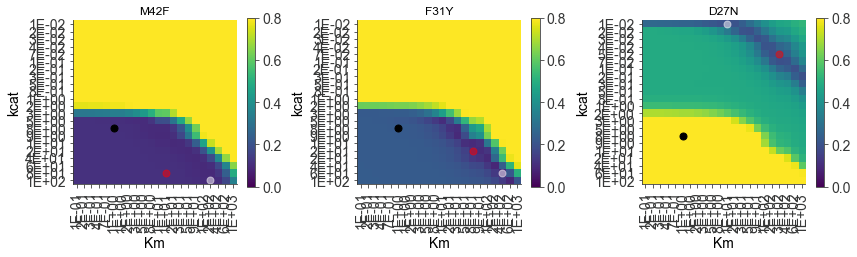

In [15]:
mut2try = ['M42F','F31Y','D27N']
plt.rcParams['figure.figsize'] = 12,12
for i,moi in enumerate(mut2try):
    plt.subplot(1,3,i+1)
    dhkcat_vary = np.sort(np.append(np.append(np.logspace(-2,2,20),DHFR_kcat[moi]),DHFR_kcat['WT']))
    dhKm_vary = np.sort(np.append(np.append(np.logspace(-1,3,20),DHFR_Km[moi]),DHFR_Km['WT']))
    ix_kcmoi = np.where(dhkcat_vary == DHFR_kcat[moi])
    ix_kmmoi = np.where(dhKm_vary == DHFR_Km[moi])
    ix_kcwt = np.where(dhkcat_vary == DHFR_kcat['WT'])
    ix_kmwt = np.where(dhKm_vary == DHFR_Km['WT'])

    gr_err = np.zeros((len(dhkcat_vary),len(dhKm_vary)))
    for i,kc in enumerate(dhkcat_vary):
        for j,km in enumerate(dhKm_vary):
            gr_err[i,j] = growth_obj([kc,km],grates_sel[DHFR_mut.index(moi),:],tskcat_sel,tskm_sel,fit_params)
        
    gr_est = calcGR(fit_params[0],fit_params[1],fit_params[1:1+len(tskcat_sel)],fit_params[1+len(tskcat_sel)],\
                    tskcat_sel,dhkcat_vary[ix_kcmoi],tskm_sel,dhKm_vary[ix_kmmoi],fit_params[2+len(tskcat_sel):])
    ix = np.where(gr_err == np.min(gr_err))
    gr_est2 = calcGR(fit_params[0],fit_params[1],fit_params[1:1+len(tskcat_sel)],fit_params[1+len(tskcat_sel)],\
                    tskcat_sel,dhkcat_vary[ix[0][0]],tskm_sel,dhKm_vary[ix[1][0]],fit_params[2+len(tskcat_sel):])
    print('Estimated growth rate %s - known params: ' % moi)
    print(gr_est)
    print('Estimated growth rate %s - best fit: ' % moi)
    print(gr_est2)
    print('Actual growth rate: ')
    print(grates_sel[DHFR_mut.index(moi),:])
    print('Error known params: %f, error best fit %f' % (np.sqrt(np.sum((gr_est - grates_sel[DHFR_mut.index(moi),:])**2)), \
                                                         np.min(gr_err)))
    
    plt.imshow(gr_err,cmap='viridis', vmin=0,vmax=0.8)
    plt.plot(ix_kmmoi,ix_kcmoi,'or',ms=7,alpha=0.5)
    plt.plot(ix_kmwt,ix_kcwt,'ok',ms=7)
    plt.plot(ix[1][0],ix[0][0],'ow',ms=7,alpha=0.5)
    plt.yticks(np.arange(0,len(dhkcat_vary)),labels=['%1.0E'%p for p in dhkcat_vary],\
                     rotation='horizontal')
    plt.xticks(np.arange(0,len(dhKm_vary)),labels=['%1.0E'%p for p in dhKm_vary],\
                     rotation='vertical')
    plt.title(moi)
    plt.colorbar(shrink=0.2)
    plt.xlabel('Km',fontsize=14)
    plt.ylabel('kcat',fontsize=14)
plt.tight_layout()
plt.savefig('Figs/CatParam_Estimate.pdf')

In the above plots, the black point marks WT kinetic parameters, red indicates the actual (experimentally measured) parameters, and white marks the best fit parameters. For M42F (left panel), which has a kcat better than WT, the model can't clearly discriminate between many "good" values for kcat and Km. 

#### Examine how the model fits the data in totality

Now we investigate how the model describes the complete data set. We start by estimating catalytic parameters for all of the single mutants (for which we have growth rate measurements)

(this next code block takes several hours to run, it can be made faster by decreasing the argument niter)
OR you can import in data that you have previously calculated. 

In [16]:
#uncomment the following to run the full calculations
'''
ekcat,ekcat_std,eKm,eKm_std = np.zeros_like(gr_mean['WT']),np.zeros_like(gr_mean['WT']),\
                              np.zeros_like(gr_mean['WT']),np.zeros_like(gr_mean['WT'])
niter=20

for p in range(Npos-1):
    print('estimating effects for position %i' % p)
    for a in range(NAA_nostop):
        grf = [gr_mean['WT'][p,a],gr_mean['Q33S'][p,a],gr_mean['R166Q'][p,a]]
        grerr = [gr_std['WT'][p,a],gr_std['Q33S'][p,a],gr_std['R166Q'][p,a]]
        if np.sum(np.isnan(grf)) > 0:
            ekcat[p,a] = np.nan
            eKm[p,a] = np.nan
            ekcat_std[p,a] = np.nan
            eKm_std[p,a] = np.nan
        else:
            sols = it_bh2(grf,grerr,niter,tskcat_sel,tskm_sel,fit_params)
            ekcat[p,a] = np.median(sols[:,0])
            eKm[p,a] = np.median(sols[:,1])
            ekcat_std[p,a] = np.std(sols[:,0])
            eKm_std[p,a] = np.std(sols[:,1])
'''

"\nekcat,ekcat_std,eKm,eKm_std = np.zeros_like(gr_mean['WT']),np.zeros_like(gr_mean['WT']),                              np.zeros_like(gr_mean['WT']),np.zeros_like(gr_mean['WT'])\nniter=20\n\nfor p in range(Npos-1):\n    print('estimating effects for position %i' % p)\n    for a in range(NAA_nostop):\n        grf = [gr_mean['WT'][p,a],gr_mean['Q33S'][p,a],gr_mean['R166Q'][p,a]]\n        grerr = [gr_std['WT'][p,a],gr_std['Q33S'][p,a],gr_std['R166Q'][p,a]]\n        if np.sum(np.isnan(grf)) > 0:\n            ekcat[p,a] = np.nan\n            eKm[p,a] = np.nan\n            ekcat_std[p,a] = np.nan\n            eKm_std[p,a] = np.nan\n        else:\n            sols = it_bh2(grf,grerr,niter,tskcat_sel,tskm_sel,fit_params)\n            ekcat[p,a] = np.median(sols[:,0])\n            eKm[p,a] = np.median(sols[:,1])\n            ekcat_std[p,a] = np.std(sols[:,0])\n            eKm_std[p,a] = np.std(sols[:,1])\n"

In [17]:
#alternatively, read in the kcat and Km estimates from a pickle file
#(e.g. calculations resulting from a previous execution of this notebook)
fin = open('Output/2023-04-17_KGfit_alldata.pkl', 'rb')
model_fits = pickle.load(fin)
ekcat = model_fits['ekcat']
ekcat_std = model_fits['ekcat_std']
eKm = model_fits['eKm']
eKm_std = model_fits['eKm_std']

Estimate back the growth rates from the best fits. 

In [18]:
gr_estall = {}
gr_estall['WT'] = np.zeros_like(gr_mean['WT'])
gr_estall['Q33S'] = np.zeros_like(gr_mean['Q33S'])
gr_estall['R166Q'] = np.zeros_like(gr_mean['R166Q'])

for p in range(Npos-1):
    for a in range(NAA_nostop):
        if ~np.isnan(ekcat[p,a]):
            gr_est = calcGR(Ftot,c_ts[0],c_ts,c_dh,tskcat_sel,ekcat[p,a],tskm_sel,eKm[p,a],g_params)
            gr_estall['WT'][p,a] = gr_est[0]
            gr_estall['Q33S'][p,a] = gr_est[1]
            gr_estall['R166Q'][p,a] = gr_est[2]
        else:
            gr_estall['WT'][p,a] = np.nan
            gr_estall['Q33S'][p,a] = np.nan
            gr_estall['R166Q'][p,a] = np.nan

Examine the correspondence between the model and the data

/Users/kimreynol/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/kimreynol/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<Figure size 576x576 with 0 Axes>

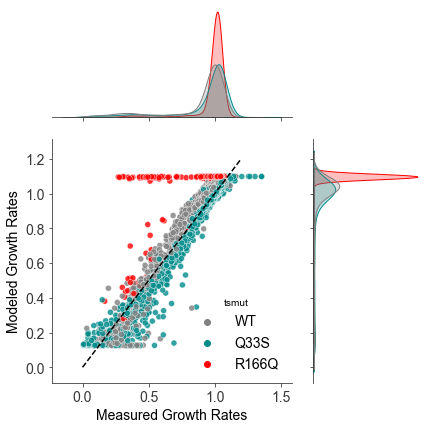

<Figure size 576x576 with 0 Axes>

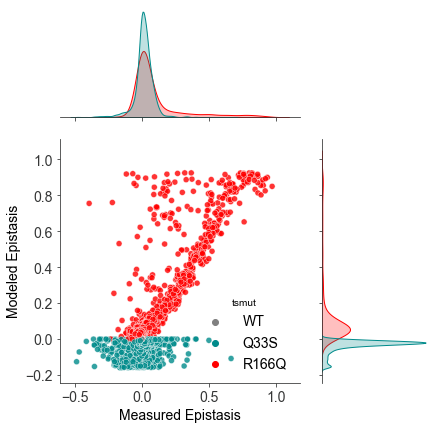

In [19]:
#create a dataframe to make seaborn plotting simpler
gr_model = {}
gr_model['dhmut'] = []
gr_model['tsmut'] = []
gr_model['gr_meas'] = np.empty(1)
gr_model['gr_mod'] = np.empty(1)
gr_model['epi_meas'] = np.empty(1)
gr_model['epi_mod'] = np.empty(1)

wt_aa_seqfull_trun = wt_aa_seqfull[1:]

ix=0
for p in range(Npos-1):
    for a in range(NAA_nostop):
        for t in TYMS_mut:
            #remove WT to prevent overcounting
            if (wt_aa_seqfull_trun[p] != AA[a]):
                gr_model['dhmut'].append(str(p+1)+AA[a])
                gr_model['tsmut'].append(t)
                if ix == 0:
                    gr_model['gr_meas'][0] = gr_mean[t][p,a]
                    gr_model['gr_mod'][0] =  gr_estall[t][p,a]
                    if t == 'WT':
                        gr_model['epi_meas'][0] = 0
                        gr_model['epi_mod'][0] = 0
                    else:
                        gr_model['epi_meas'][0] = epi[t][p,a]
                        gr_model['epi_mod'][0] = gr_estall[t][p,a] - gr_estall['WT'][p,a]
                else:
                    gr_model['gr_meas'] = np.append(gr_model['gr_meas'],gr_mean[t][p,a])
                    gr_model['gr_mod'] = np.append(gr_model['gr_mod'], gr_estall[t][p,a])
                    if t == 'WT':
                        gr_model['epi_meas'] = np.append(gr_model['epi_meas'],0)
                        gr_model['epi_mod'] = np.append(gr_model['epi_mod'],0)
                    else:
                        gr_model['epi_meas'] = np.append(gr_model['epi_meas'],epi[t][p,a])
                        gr_model['epi_mod'] = np.append(gr_model['epi_mod'],gr_estall[t][p,a] - gr_estall['WT'][p,a])
                ix += 1

df_grmodel = pd.DataFrame(gr_model)

plt.figure(figsize=(8,8))
g = sns.jointplot(data=df_grmodel,x="gr_meas",y="gr_mod",hue="tsmut",palette=["grey","darkcyan","red"],\
                  ratio=2,joint_kws=dict(alpha=0.8))


plt.sca(g.ax_joint)
plt.plot([0,1.2],[0,1.2],'--k')
g.ax_joint.set_xlabel(('Measured Growth Rates'),fontsize=14)
g.ax_joint.set_ylabel(('Modeled Growth Rates'),fontsize=14)

#plt.plot(gr_mean['WT'].flatten(),gr_estall['WT'].flatten(),'o',markersize=6,color='grey',mec='grey',alpha=0.5)
#plt.plot(gr_mean['Q33S'].flatten(),gr_estall['Q33S'].flatten(),'o',markersize=6,color='cyan',mec='grey',alpha=0.5)
#plt.plot(gr_mean['R166Q'].flatten(),gr_estall['R166Q'].flatten(),'o',markersize=6,color='red',mec='grey',alpha=0.5)
#plt.plot([0, 1],[0, 1],'--k',linewidth=0.5)
#plt.xlabel('Measured Growth Rates', fontsize=14)
#plt.ylabel('Model Growth Rates', fontsize=14)
plt.savefig('Figs/FullModelFit.pdf')

plt.figure(figsize=(8,8))
g = sns.jointplot(data=df_grmodel,x="epi_meas",y="epi_mod",hue="tsmut",palette=["grey","darkcyan","red"],\
                  ratio=2,joint_kws=dict(alpha=0.8))
g.ax_joint.set_xlabel(('Measured Epistasis'),fontsize=14)
g.ax_joint.set_ylabel(('Modeled Epistasis'),fontsize=14)
plt.savefig('Figs/FullModelFit_Epi.pdf')


In [20]:
#calculate the fraction of TYMS mutations incorrectly predicted to rescue growth 
tot_incorr_pred = len(np.where((df_grmodel[df_grmodel.tsmut == 'R166Q'].gr_meas < 0.9) & \
                               (df_grmodel[df_grmodel.tsmut == 'R166Q'].gr_mod > 1))[0])
frac_incorr_pred = tot_incorr_pred/(2696)

print(f'{tot_incorr_pred}, {frac_incorr_pred}% DHFR mutants were incorrectly predicted as rescuing in the TYMS R166Q background')

70, 0.02596439169139466% DHFR mutants were incorrectly predicted as rescuing in the TYMS R166Q background


#### A direct comparision between the distribution of mutational effects (and distribution of epistasis) that is predicted by the model and observed experimentally

In [21]:
#first, necessary functions for fitting the double gaussian
def double_gaussian( x, params ):
    (c1, mu1, sigma1, c2, mu2, sigma2) = params
    res =   c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) ) \
          + c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) )
    return res

def double_gaussian_fit( params ):
    x = data[0]
    y_proc =data[1]
    fit = double_gaussian( x, params )
    return (fit - y_proc)

Double Gaussian fit for WT TYMS : *******
C1: 507.942, M1 1.047, S1 0.0234
C2: 9.635, M2 0.500, S2 0.5938
Double Gaussian fit for Q33S TYMS : *******
C1: 350.387, M1 1.027, S1 0.0332
C2: 11.301, M2 0.500, S2 0.4968
Double Gaussian fit for R166Q TYMS : *******
C1: 578.626, M1 1.098, S1 0.0061
C2: 0.988, M2 0.314, S2 0.0887


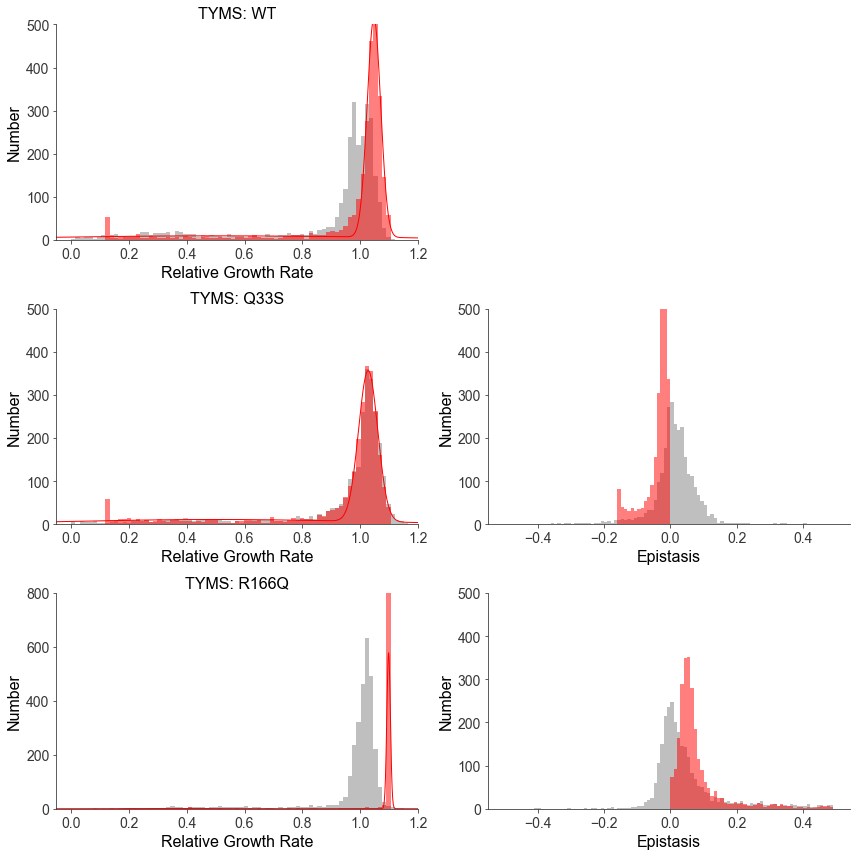

In [22]:
plt.rcParams['figure.figsize'] = 12,12

#freedman-diaconis rule for deciding binwidth (h)
#using the Q33S data since it seems to show
#the most variance in growth rate.
grates_flat = np.ma.array(gr_mean['Q33S'],mask=WTAAmask,fill_value = np.nan).filled().flatten()
grates_filter = grates_flat[~np.isnan(grates_flat)] 
h = 2*stats.iqr(grates_filter)/(len(grates_filter)**(1/3))
bin_edges = np.arange(0,1.5,h)
ylim_ts = [500, 500, 800]

#set binwidth for epistasis as well
bin_edges_epi = np.arange(-0.5,0.5,.01)

for i,ts in enumerate(['WT','Q33S','R166Q']):
    
    #First plotting the distribution of mutational effects in each TYMS background
    plt.subplot(3,2,(i*2)+1)
    #filter out the WT entries in the matrix, to prevent overcounting
    grates_flat = np.ma.array(gr_mean[ts],mask=WTAAmask,fill_value = np.nan).filled().flatten()
    grates_filter = np.append(grates_flat[~np.isnan(grates_flat)],1)
    
    grates_est_flat = np.ma.array(gr_estall[ts],mask=WTAAmask,fill_value = np.nan).filled().flatten()
    grates_est_filter = np.append(grates_est_flat[~np.isnan(grates_est_flat)],1)
    
    n,bins,patches = plt.hist(grates_filter,bins=bin_edges,alpha=0.5, color='grey')
    n,bins,patches = plt.hist(grates_est_filter,bins=bin_edges, alpha=0.5, color='red')
    
    #fit the double gaussian
    x = [(bins[k]+bins[k+1])/2 for k in range(len(bins)-1)]
    data = [x,n]
    #dgaussfit = leastsq(double_gaussian_fit, [2000,1,0.1,10,0.2,0.3],args=[x,n])
    dgaussfit = least_squares(double_gaussian_fit, [2000,1,0.1,10,0.2,0.3], \
                              bounds=[[0,0.7,0,0,-0.2,0],[2500,1.5,1.0,2500,0.5,1.0]])
    c1=dgaussfit.x[0]; m1=dgaussfit.x[1]; s1=abs(dgaussfit.x[2])
    c2=dgaussfit.x[3]; m2=dgaussfit.x[4]; s2=abs(dgaussfit.x[5])
    plt.plot(np.arange(-0.05,1.2,0.001),\
             double_gaussian(np.arange(-0.05,1.2,0.001),[c1,m1,s1,c2,m2,s2]),'r-',linewidth = 1)
    
    plt.xlim([-0.05,1.2]); 
    plt.ylim([0,ylim_ts[i]])
    plt.xlabel('Relative Growth Rate',fontsize=16); plt.ylabel('Number',fontsize=16)
    plt.title('TYMS: '+ts,fontsize=16)
    
    print('Double Gaussian fit for %s TYMS : *******' % ts)
    print ('C1: %3.3f, M1 %1.3f, S1 %1.4f' % (c1,m1,s1))
    print ('C2: %3.3f, M2 %1.3f, S2 %1.4f' % (c2,m2,s2))
    
    if ts != 'WT':
        #Now plotting the distribution of epistasis in each TYMS background
        plt.subplot(3,2,(i*2)+2)

        #filter out the WT entries in the matrix, to prevent overcounting
        epi_flat = np.ma.array(epi[ts],mask=WTAAmask,fill_value = np.nan).filled().flatten()
        epi_filter = np.append(epi_flat[~np.isnan(epi_flat)],1)
    
        epi_est_flat = np.ma.array(gr_estall[ts]-gr_estall['WT'],mask=WTAAmask,fill_value = np.nan).filled().flatten()
        epi_est_filter = np.append(epi_est_flat[~np.isnan(epi_est_flat)],1)
    
        n,bins,patches = plt.hist(epi_filter,bins=bin_edges_epi,alpha=0.5, color='grey')
        n,bins,patches = plt.hist(epi_est_filter,bins=bin_edges_epi, alpha=0.5, color='red')

        plt.xlabel('Epistasis',fontsize=16); plt.ylabel('Number',fontsize=16)
        plt.ylim([0,500])
plt.tight_layout()
plt.savefig('Figs/DFEs_wMod.pdf')


#### Given these estimates, let's examine the mutational tolerance of DHFR as a function of TYMS activity 

To do this we computationally vary TYMS activity and calculate the number of DHFR mutations with near-neutral effects on growth rate (given their estimated kcat and Km values)

In [23]:
#sample TYMS kcat and Km logarithmically, append the experimental values
#for our reference mutants (TYMS WT,Q33S and R166Q)
#remember to scale the kcat of each by the appropriate abundance
q33_fitA = fit_params[2]/fit_params[1]
r166_fitA = fit_params[3]/fit_params[1]
tskcat_vary = np.sort(np.append(np.append(np.append(\
                            np.logspace(-2,2,50),TYMS_kcat['WT']),TYMS_kcat['Q33S']*q33_fitA),\
                                TYMS_kcat['R166Q']*r166_fitA))
tskm_vary = np.sort(np.append(np.append(np.append(\
                            np.logspace(-1,3,50),TYMS_Km['WT']),TYMS_Km['Q33S']),TYMS_Km['R166Q']))

ix_kcQ33 = np.where(tskcat_vary == TYMS_kcat['Q33S']*q33_fitA)
ix_kmQ33 = np.where(tskm_vary == TYMS_Km['Q33S'])
ix_kcWT = np.where(tskcat_vary == TYMS_kcat['WT'])
ix_kmWT = np.where(tskm_vary == TYMS_Km['WT'])
ix_kcR166 = np.where(tskcat_vary == TYMS_kcat['R166Q']*r166_fitA)
ix_kmR166 = np.where(tskm_vary == TYMS_Km['R166Q'])

#growth rate calculations for ALL DHFR single mutations across these 400 simulated TYMS backgrounds
#note that I am using the fit intracellular abundance of WT TYMS across all calcuations
grsim_tsvary = np.zeros((len(tskcat_vary),len(tskm_vary),len(ekcat.flatten())))
for i,tkc in enumerate(tskcat_vary):
    for j,tkm in enumerate(tskm_vary):
        grsim_tsvary[i,j,:] = calcGR(fit_params[0],fit_params[1],fit_params[1],fit_params[1+len(tskcat_sel)],\
                                    tkc,ekcat.flatten(),tkm,eKm.flatten(),fit_params[2+len(tskcat_sel):])

print(f'Simulated rowth rate calculations complete for {len(ekcat.flatten())} \
DHFR mut and {(len(tskcat_vary)*len(tskm_vary))} TYMS mut)')

Simulated rowth rate calculations complete for 3160 DHFR mut and 2809 TYMS mut)


In [24]:
#Now, given the growth rate calculations, compute the fraction "neutral" at each TYMS kcat
#and at each TYMS velocity

#We examine this for several thresholds of neutrality to make sure the results are not specific to
#a particular choice of cutoffs
neutral_cut = [ 0.7, 0.8, 0.85, 0.9]
frac_neutral = np.zeros((len(tskcat_vary),len(tskm_vary),len(neutral_cut)))
for i,c in enumerate(neutral_cut):
    for j in range(len(tskcat_vary)):
        for k in range(len(tskm_vary)):
            frac_neutral[j,k,i] = np.sum(grsim_tsvary[j,k,:] > c)/len(ekcat.flatten())

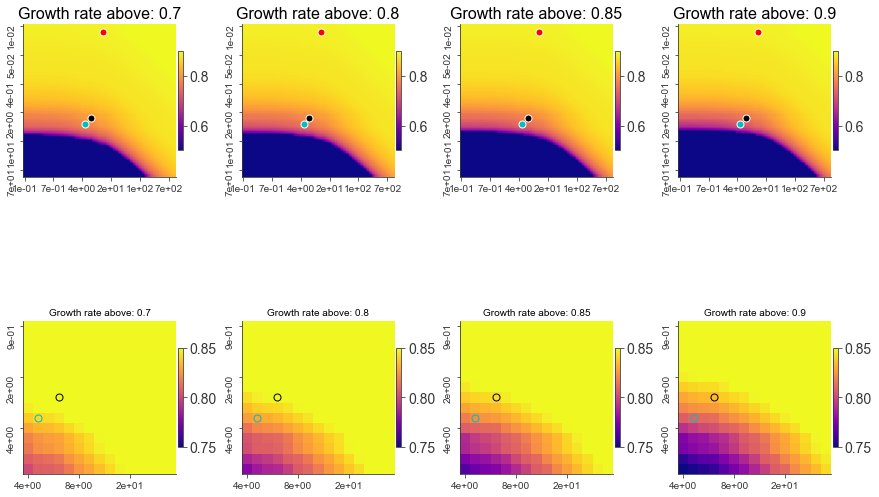

In [25]:
#Plot the resulting landscapes of fitness effects (given variation in TYMS activity)
plt.rcParams['figure.figsize'] = 15,10

for i,c in enumerate(neutral_cut):
    plt.subplot(2,len(neutral_cut),i+1)
    plt.imshow(frac_neutral[:,:,i],cmap='plasma', vmin=0.5, vmax=0.9)
    plt.plot(ix_kmWT,ix_kcWT,'ok',ms=7,mec='w')
    plt.plot(ix_kmQ33,ix_kcQ33,'oc',ms=7,mec='w')
    plt.plot(ix_kmR166,ix_kcR166,'or',ms=7,mec='w')
    plt.colorbar(shrink = 0.4, orientation = 'vertical', pad = 0.01)
    
    plt.title(F'Growth rate above: {c}',fontsize=16)
    plt.yticks(np.arange(0,len(tskcat_vary),10),rotation='vertical',fontsize=10,\
                             labels=['%1.0e' %tskcat_vary[i] for i in np.arange(0,len(tskcat_vary),10)])
    plt.xticks(np.arange(0,len(tskm_vary),10),fontsize=10,\
                             labels=['%1.0e' %tskm_vary[i] for i in np.arange(0,len(tskm_vary),10)])
    
    plt.subplot(2,len(neutral_cut),i+1+len(neutral_cut))
    plt.imshow(frac_neutral[20:35,25:40,i],cmap='plasma', vmin=0.75, vmax=0.85)
    plt.plot(ix_kmWT[0]-20,ix_kcWT[0]-25,'o',ms=7,mec='k',mfc='#FFFFFF00')
    plt.plot(ix_kmQ33[0]-20,ix_kcQ33[0]-25,'o',ms=7,mec='c',mfc='#FFFFFF00')
    plt.colorbar(shrink = 0.4, orientation = 'vertical', pad = 0.01)
    
    plt.title(F'Growth rate above: {c}',fontsize=10)
    plt.yticks(np.arange(0,15,5),rotation='vertical',fontsize=10,\
                             labels=['%1.0e' %tskcat_vary[i] for i in np.arange(25,40,5)])
    plt.xticks(np.arange(0,15,5),fontsize=10,\
                             labels=['%1.0e' %tskm_vary[i] for i in np.arange(20,35,5)])

#plt.tight_layout()    
plt.savefig('Figs/TYMSneutral_landscapes.pdf')

#### Plot the data onto fitness landscapes described by the model

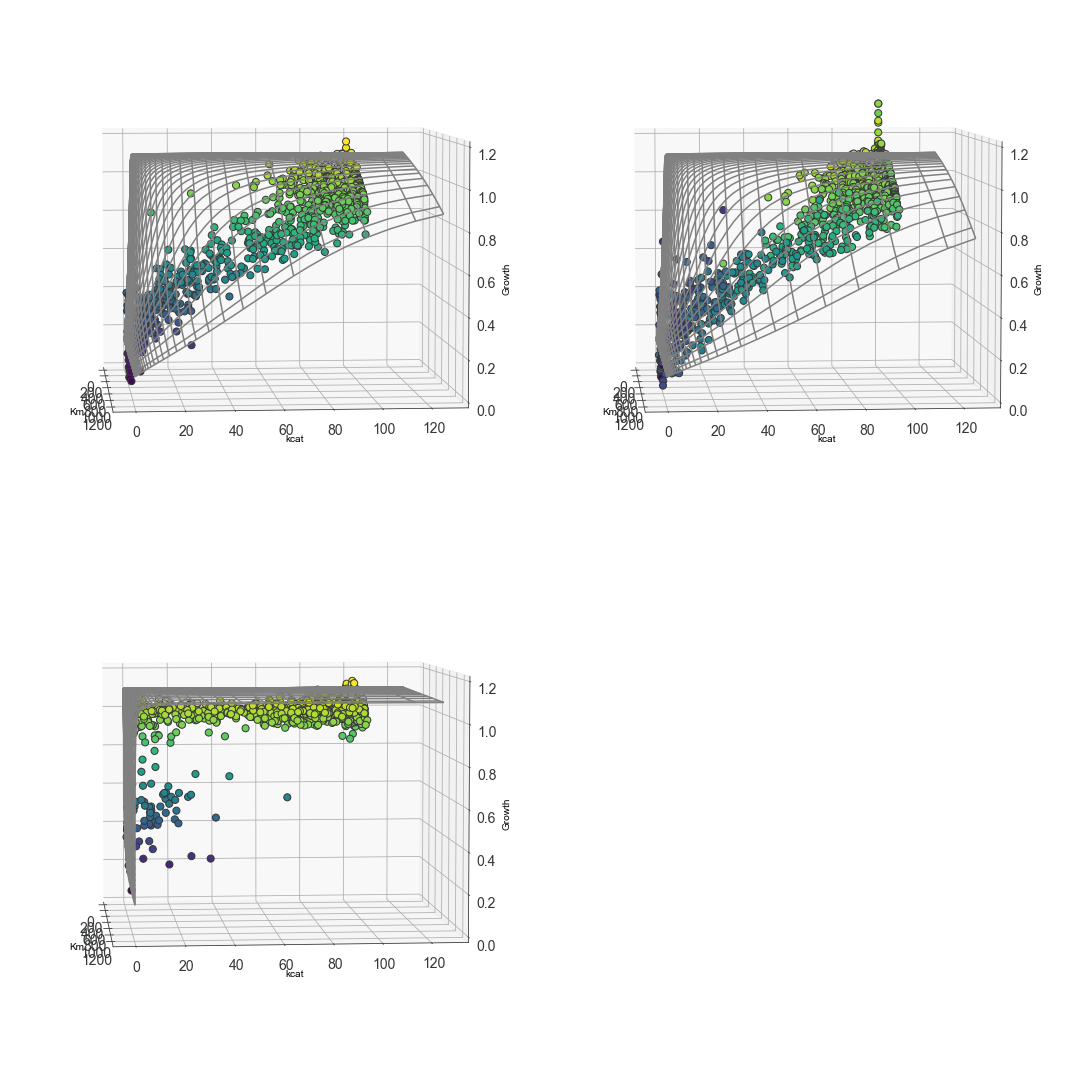

In [26]:
dhkcat_vary = np.logspace(-2,2.1,100)
dhKm_vary = np.logspace(-1,3.1,100)
gr_surf = {}
gr_surf['WT'] = np.zeros((len(dhkcat_vary),len(dhKm_vary)))
gr_surf['Q33S'] = np.zeros((len(dhkcat_vary),len(dhKm_vary)))
gr_surf['R166Q'] = np.zeros((len(dhkcat_vary),len(dhKm_vary)))

for i,kc in enumerate(dhkcat_vary):
    for j,km in enumerate(dhKm_vary):
        gr = calcGR(Ftot,c_ts[0],c_ts,c_dh,tskcat_sel,kc,tskm_sel,km,g_params)
        gr_surf['WT'][i,j] = gr[0]
        gr_surf['Q33S'][i,j] = gr[1]
        gr_surf['R166Q'][i,j] = gr[2]
        
X,Y = np.meshgrid(dhKm_vary,dhkcat_vary)

plt.figure(figsize=(15,15))

ax=plt.subplot(221,projection='3d')
ax.plot_wireframe(X,Y,gr_surf['WT'],color='grey')
ax.scatter3D(eKm.flatten(),ekcat.flatten(),gr_mean['WT'][:,:20].flatten(),c=gr_mean['WT'][:,:20].flatten(),\
             cmap='viridis',alpha=1,s=50)
ax.set_zlim([0,1.2])
ax.view_init(5,-5)
ax.set_xlabel('Km')
ax.set_ylabel('kcat')
ax.set_zlabel('Growth')

ax = plt.subplot(222,projection='3d')
ax.plot_wireframe(X,Y,gr_surf['Q33S'],color='grey')
ax.scatter3D(eKm.flatten(),ekcat.flatten(),gr_mean['Q33S'][:,:20].flatten(),c=gr_mean['WT'][:,:20].flatten(),\
             cmap='viridis',alpha=1, s=50)
ax.set_zlim([0,1.2])
ax.view_init(5,-5)
ax.set_xlabel('Km')
ax.set_ylabel('kcat')
ax.set_zlabel('Growth')

ax = plt.subplot(223,projection='3d')
ax.plot_wireframe(X,Y,gr_surf['R166Q'],color='grey')
ax.scatter3D(eKm.flatten(),ekcat.flatten(),gr_mean['R166Q'][:,:20].flatten(),c=gr_mean['R166Q'][:,:20].\
             flatten(),cmap='viridis',alpha=1,s=50)
ax.set_zlim([0,1.2])
ax.view_init(5,-5)
ax.set_xlabel('Km')
ax.set_ylabel('kcat')
ax.set_zlabel('Growth')

plt.tight_layout()
plt.savefig('Figs/FullModelFit_landscapes.pdf')

#### How do the distributions of kinetic parameters map to our categories of epistatic positions?

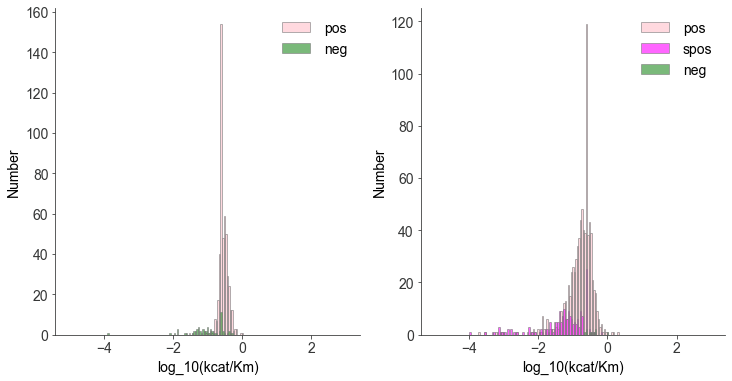

In [27]:
kcatKm_vals = {}
epi_cat = ['pos','spos','neg']

#organize the estimated kcat/Km values into a dictionary
log_kcatKm = np.log10(ekcat/eKm)
log_kcatKm_nn = log_kcatKm[np.where(~np.isnan(log_kcatKm))]
for ts in TYMS_mut[1:]:
    kcatKm_vals[ts] = {}
    for c in epi_cat:
        for i,p in enumerate(epi_clust[ts][c]):
            if i == 0:
                nn = np.where(~np.isnan(log_kcatKm[p,:]) & ~np.isnan(epi_sig[ts][p,:]))
                kcatKm_vals[ts][c] = log_kcatKm[p][nn]
            else:
                nn = np.where(~np.isnan(log_kcatKm[p,:]) & ~np.isnan(epi_sig[ts][p,:]))
                kcatKm_vals[ts][c] = np.append(kcatKm_vals[ts][c],log_kcatKm[p][nn])
                
#create the plots
plt.figure(figsize = (12,6))
h = 2*stats.iqr(log_kcatKm_nn)/(len(log_kcatKm_nn)**(1/3))
col = ['pink','magenta','forestgreen']
bin_edges = np.arange(-5,3,h)
for i,ts in enumerate(TYMS_mut[1:]):
    plt.subplot(1,2,i+1)
    for j,c in enumerate(epi_cat):
        if c in kcatKm_vals[ts].keys():
            plt.hist(kcatKm_vals[ts][c],bins=bin_edges,alpha=0.6,edgecolor='grey',label=c,color=col[j])
    plt.legend()
    plt.xlabel('log_10(kcat/Km)',fontsize=14)
    plt.ylabel('Number',fontsize=14)
plt.savefig('Figs/MutEffByEpiCat.pdf')

#### And how does predicted mutational effect track with distance from the active site?

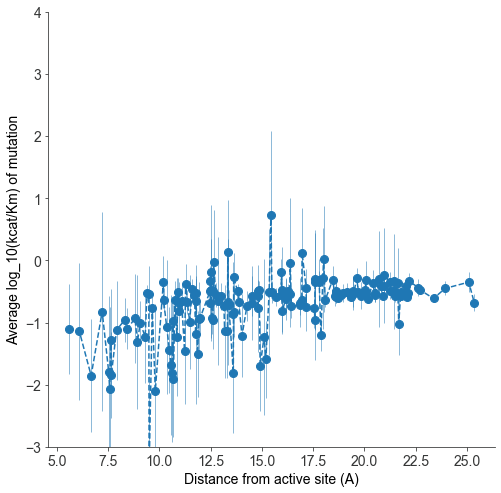

In [28]:
for i,r in enumerate(res_distsort):
    if i == 0:
        kcatKm_dist = np.nanmean(log_kcatKm[r])
        kcatKm_dist_std = np.nanstd(log_kcatKm[r])
    else:
        kcatKm_dist = np.append(kcatKm_dist,np.nanmean(log_kcatKm[r]))
        kcatKm_dist_std = np.append(kcatKm_dist_std,np.nanstd(log_kcatKm[r]))

plt.figure(figsize = (8,8))
#plt.figure(figsize = (16,10))
#plt.subplot(211)
plt.errorbar(distsort,kcatKm_dist,yerr=kcatKm_dist_std,linestyle='--',marker='o',markersize=8,elinewidth=0.5)
plt.ylim([-3,4])
plt.ylabel('Average log_10(kcat/Km) of mutation',fontsize=14)
plt.xlabel('Distance from active site (A)',fontsize=14)
plt.savefig('Figs/MutEffDist.pdf')

#plt.subplot(212)
#mask = ~np.isnan(log_kcatKm)
#filtered_kcatKm = [d[m] for d, m in zip(log_kcatKm, mask)]
#plt.violinplot(filtered_kcatKm)
#plt.xticks(np.arange(0,len(log_kcatKm)),\
#                    labels=[k+1 for k in res_distsort],fontsize=8)
#plt.tight_layout()
#plt.savefig('Figs/MutEffbyPos.pdf')

#### We create a modified PDB with the average log(kcat/Km) of mutation at a position encoded in the B-factor

In [29]:
dhfr_pdb = PandasPdb().fetch_pdb('1rx2')
dhfr_pdb.read_pdb
dhfr_pdb.df['HETATM'].loc[:,'b_factor'] = 0
for a in range(len(dhfr_pdb.df['ATOM'])):
    res_ix = dhfr_pdb.df['ATOM'].loc[a,'residue_number'] - 2
    if res_ix < 0:
        dhfr_pdb.df['ATOM'].loc[a,'b_factor'] = np.log10(DHFR_kcat['WT']/DHFR_Km['WT'])
    else:
        dhfr_pdb.df['ATOM'].loc[a,'b_factor'] = np.nanmean(log_kcatKm[res_ix])
        
dhfr_pdb.to_pdb(path='Output/1RX2_estkcatKm.pdb', records=None, gz=False, append_newline=True)

In [53]:
#getting a sense of the scale of variation in catalysis (kcat/Km)
print('MAX')
print(10**(np.nanmax(np.nanmean(log_kcatKm,1))))
print('MIN')
print(10**(np.nanmin(np.nanmean(log_kcatKm,1))))
print('WT')
print(10**(np.log10(DHFR_kcat['WT']/DHFR_Km['WT'])))
print('G97') #medium effect
print(10**(np.nanmean(log_kcatKm[95,:])))
print('G121') #large effect
print(10**(np.nanmean(log_kcatKm[119,:])))

MAX
5.474565208493983
MIN
0.000401322546223946
WT
7.2272727272727275
G97
0.10586726992799868
G121
0.02014456847997863


#### Examine the relationship between positions associated to catalysis and the sector

Average positional effect size: -0.7236594526654921, std: 0.49041438989227415
Positions with large effects on catalysis: 
5+14+15+22+27+31+35+41+43+46+54+57+93+95+96+100+103+113+121+122
34 Positions with medium effects on catalysis: 
3+4+5+6+14+15+17+20+22+27+31+35+41+43+46+49+50+54+57+61+93+94+95+96+97+100+103+111+113+121+122+125+133+148
At sector definition: 0.005 with 23 positions:
15+21+27+28+31+32+35+37+42+44+51+54+55+57+59+63+77+81+94+113+121+125+133
[[ 11.  12.]
 [ 23. 113.]]
p-value of the association is: 0.0020
At sector definition: 0.008 with 36 positions:
11+15+21+22+27+28+31+32+35+37+39+40+42+44+47+50+51+54+55+56+57+59+63+64+77+81+94+100+111+113+121+122+125+126+133+153
[[ 16.  20.]
 [ 18. 105.]]
p-value of the association is: 0.0003
At sector definition: 0.010 with 40 positions:
3+11+15+21+22+27+28+31+32+35+37+39+40+42+44+47+49+50+51+52+54+55+56+57+59+63+64+77+81+90+94+100+111+113+121+122+125+126+133+153
[[ 18.  22.]
 [ 16. 103.]]
p-value of the association is: 0.0001
At se

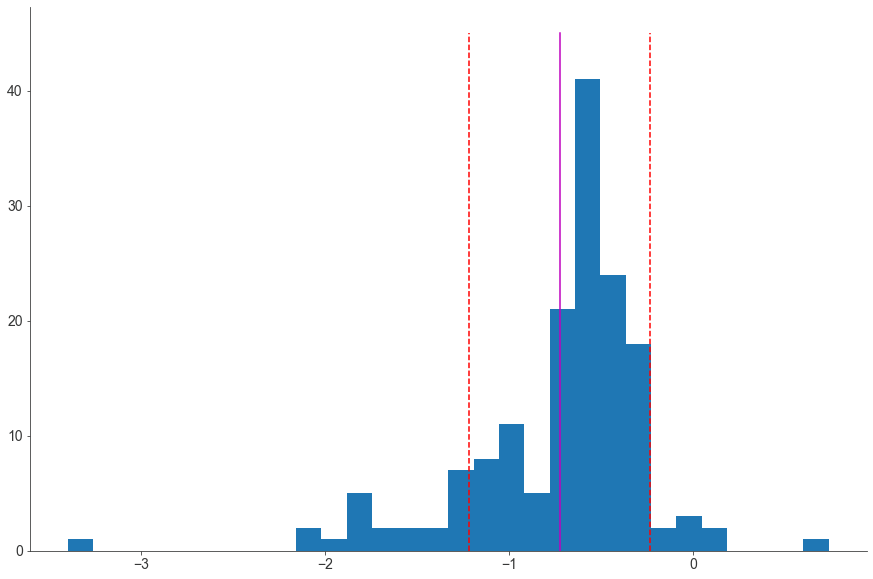

In [30]:
#First we examine the distribution of catalytic effects
pos_log_cateffect = np.nanmean(log_kcatKm,axis=1)
plt.hist(pos_log_cateffect,30)
mean_effsize = np.mean(pos_log_cateffect)
std_effsize = np.std(pos_log_cateffect)
print(f'Average positional effect size: {mean_effsize}, std: {std_effsize}')
plt.plot([mean_effsize,mean_effsize],[0,45], 'm-')
plt.plot([mean_effsize-std_effsize,mean_effsize-std_effsize],[0,45], 'r--')
plt.plot([mean_effsize+std_effsize,mean_effsize+std_effsize],[0,45], 'r--')

#Now we consider all positions with deleterious mutational effects lower than
#one standard deviations away from the mean
cat_pos_lg = np.where(pos_log_cateffect < (mean_effsize-std_effsize))[0] 
cat_pos_med = np.where(pos_log_cateffect < (mean_effsize-(std_effsize*0.5)))[0] 
print('Positions with large effects on catalysis: ')
print('+'.join([str(k+2) for k in cat_pos_lg]))
                       
print('%i Positions with medium effects on catalysis: ' % (len(cat_pos_med)))
print('+'.join([str(k+2) for k in cat_pos_med]))
                       
#Let's compare these to the sector by a fisher exact test
#here we take the sector definition from Reynolds et al 2011 at four
#stringency cutoffs
sec_def = [[15,21,27,28,31,32,35,37,42,44,51,54,55,57,59,63,77,81,94,113,121,125,133],\
           [11,15,21,22,27,28,31,32,35,37,39,40,42,44,47,50,51,54,55,56,57,59,63,64,77,\
            81,94,100,111,113,121,122,125,126,133,153],\
           [3,11,15,21,22,27,28,31,32,35,37,39,40,42,44,47,49,50,51,52,54,55,56,57,59,\
            63,64,77,81,90,94,100,111,113,121,122,125,126,133,153],\
           [3,5,11,13,15,18,21,22,25,27,28,31,32,35,37,39,40,42,44,45,47,49,50,51,52,\
            53,54,55,56,57,59,63,64,77,81,90,94,95,99,100,107,111,113,121,122,125,126,133,\
            153]]
sec_cut = ['0.005','0.008','0.010','0.015']
cat_pos = set(k+2 for k in cat_pos_med)
for i,sec in enumerate(sec_def):
    cont_table = np.zeros((2,2))
    cont_table[0,0] = len(cat_pos.intersection(sec))
    cont_table[1,0] = len(cat_pos) - cont_table[0,0]
    cont_table[0,1] = len(sec)-cont_table[0,0]
    cont_table[1,1] = (159-len(sec))-cont_table[1,0]
    
    print('At sector definition: %s with %i positions:'%(sec_cut[i],len(sec)))
    print('+'.join([str(k) for k in sec]))
    print(cont_table)
    result = stats.fisher_exact(cont_table)
    print("p-value of the association is: %1.4f" % (result[1]))
    
#As a reference we also compare these to evolutionary conservation
cons_def = [[7,14,15,21,22,27,31,35,42,43,44,46,47,54,57,61,63,95,96,100,113,122,133],\
            [5,7,14,15,20,21,22,27,31,35,40,41,42,43,44,46,47,49,54,55,57,59,61,63,64,94,95,96,100,113,115,122,125,126,133,153],\
            [5,7,14,15,20,21,22,27,31,35,40,41,42,43,44,45,46,47,49,54,55,57,59,60,61,63,64,94,95,96,99,100,113,115,121,122,125,126,133,153],\
            [5,7,11,14,15,18,20,21,22,27,31,32,35,40,41,42,43,44,45,46,47,48,49,50,54,55,57,59,60,61,63,64,92,93,94,95,96,99,100,113,115,121,\
             122,125,126,133,153,156,158]]
cons_cut = [1.89,1.54,1.49,1.38]
for i,cons in enumerate(cons_def):
    cont_table = np.zeros((2,2))
    cont_table[0,0] = len(cat_pos.intersection(cons))
    cont_table[1,0] = len(cat_pos) - cont_table[0,0]
    cont_table[0,1] = len(cons)-cont_table[0,0]
    cont_table[1,1] = (159-len(cons))-cont_table[1,0]
    
    print('At conservation definition: %s with %i positions:'%(cons_cut[i], len(cons)))
    print('+'.join([str(k) for k in cons]))
    print(cont_table)
    result = stats.fisher_exact(cont_table)
    print("p-value of the association is: %1.4e" % (result[1]))

#### Finally, lets examine the full fitness landscape for the relative activities of DHFR and TYMS, in analogy to Dykhuizen, Dean and Hartl, 1987, Genetics.  Here we plot growth rate as a function of varying the effective kcat of each enzyme.

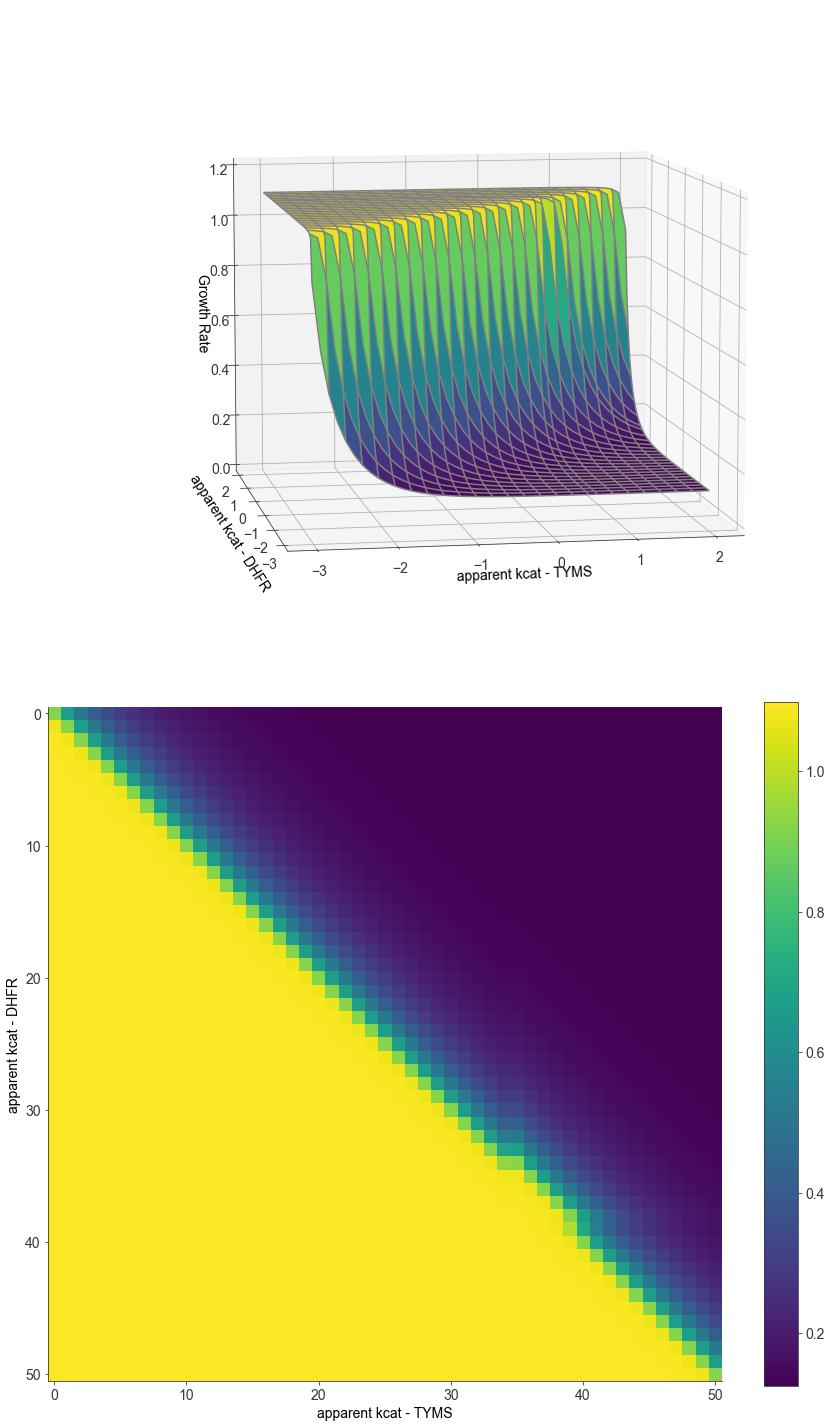

In [31]:
#define a range of perturbations across both DHFR and TYMS
dhkcat_vary = np.sort(np.append(np.logspace(-3,2,50),DHFR_kcat['WT']))
tskcat_vary = np.sort(np.append(np.logspace(-3,2,50),TYMS_kcat['WT']))
ix_kcwtdh = np.where(dhkcat_vary == DHFR_kcat['WT'])
ix_kcwtts = np.where(tskcat_vary == TYMS_kcat['WT'])

gr_landscape = np.zeros((len(dhkcat_vary),len(tskcat_vary)))
thfWT = concTHF(Ftot,c_ts[0],c_dh,TYMS_kcat['WT'],DHFR_kcat['WT'],TYMS_Km['WT'],DHFR_Km['WT'])
thfMut = np.zeros((len(dhkcat_vary),len(tskcat_vary)))
for i,d_kc in enumerate(dhkcat_vary):
    for j,t_kc in enumerate(tskcat_vary):
        thfMut[i,j] = concTHF(Ftot,c_ts[0],c_dh,t_kc,d_kc,TYMS_Km['WT'],DHFR_Km['WT'])
        relTHF = thfMut[i,j]/thfWT
        gr_landscape[i,j] = gr_depSigmoid(g_params[0],g_params[1],g_params[2],g_params[3],relTHF)

#create the landscape plot
plt.figure(figsize=(12,20))

ax=plt.subplot(211,projection='3d')
X,Y = np.meshgrid(tskcat_vary,dhkcat_vary)
ax.plot_surface(np.log10(X),np.log10(Y),gr_landscape,cmap='viridis')
ax.plot_wireframe(np.log10(X),np.log10(Y),gr_landscape,color='grey')
#ax.scatter3D(TYMS_kcat['WT'],DHFR_kcat['WT'],1,c='k',s=80)
#ax.scatter3D(TYMS_kcat['Q33S'],DHFR_kcat['WT'],1,c='c',s=80)
#ax.scatter3D(TYMS_kcat['R166Q'],DHFR_kcat['WT'],1,c='r',s=80)
ax.set_zlim([0,1.2])
ax.view_init(8,-100)
ax.set_xlabel('apparent kcat - TYMS', fontsize=14)
ax.set_ylabel('apparent kcat - DHFR', fontsize=14)
ax.set_zlabel('Growth Rate', fontsize=14)

ax=plt.subplot(212)
plt.imshow(gr_landscape)
plt.colorbar()
ax.set_xlabel('apparent kcat - TYMS', fontsize=14)
ax.set_ylabel('apparent kcat - DHFR', fontsize=14)

plt.tight_layout()
plt.savefig('Figs/DHTS_landscape.pdf')

#### Write the results of our model fitting and parameter estimation to a pickle file

In [32]:
model_fits = {}
model_fits['Ftot'] = Ftot
model_fits['c_ts'] = c_ts
model_fits['c_dh'] = c_dh
model_fits['g_params'] = g_params
model_fits['ekcat'] = ekcat
model_fits['ekcat_std'] = ekcat_std
model_fits['eKm'] = eKm
model_fits['eKm_std'] = eKm_std 
model_fits['gr_est'] = gr_est

today = date.today()
fout = open(f'Output/{today}_KGfit_alldata.pkl','wb')
pickle.dump(model_fits,fout, protocol=pickle.HIGHEST_PROTOCOL)
fout.close()